# ML Workflow for Predictive Maintenance Case 2 - (MyToolBox)

## Binary classification ##

<i>Python notebook created on April 2019. </i>
* Edited by <b>Karim Choukri.</b> (kchoukri012@gmail.com)

The objective of this project is to predict the probability of failure of a machine in the near future. <br>
Therefore, it is possible to deal with costs related to mechanical failures in advance and acting preventatively, saving time and money.

For that specific problem, we are given a set of anonymized variables measured throughout regular time basis units (cycles). These variables are captured for a set of assets (machine id's). Based on these features, we must build a model that allows us to predict the set of assets (machines) that will fail within the next time window fixed at 30 cycles.

We are given a 'training' dataset, a 'test' dataset and a 'truth' table that provides for each machine (id), the number of days (cycles) left before failure.

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, accuracy_score, precision_score
from sklearn.metrics import roc_curve, auc, classification_report, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import scikitplot as skplt
from scipy import interp
from itertools import cycle

import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier as xgb

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
from keras import optimizers


%matplotlib inline  

Using TensorFlow backend.


In [2]:
# Others
import warnings
# General settings
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")
#plt.rc("font", family="serif", size=10)
#plt.style.use('ggplot')

### Useful functions

In [3]:
# One Hot encoding of target values (labels)
def one_hot(n_classes, y):
    return np.eye(n_classes)[y-1]

In [4]:
# Classifier performance evaluation (confusion matrix, accuracy, precision, recall, F1 scores)

def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    #print("Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels")
    #print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(["accuracy", "precision", "recall", "F1"])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(["macro precision", "macro recall", "macro F1"])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(["average accuracy",
                          "micro-averaged precision/recall/F1"])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(["majority class accuracy", "majority class recall",
                          "majority class precision", "majority class F1"])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(["expected accuracy", "kappa"])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(["random guess accuracy", "random guess precision",
                          "random guess recall", "random guess F1"])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(["random weighted guess accuracy",
                          "random weighted guess precision",
                          "random weighted guess recall",
                          "random weighted guess F1"])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df

In [5]:
# ROC curve plotting (Binary classification)
def plot_binary_roc_curve(target_test, target_predicted_proba, fig = 1):

    #horizon, n_classes = target_predicted_proba.shape
    n_classes = 1
    yy_test = target_test  # binary classification

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
        
    fpr[0], tpr[0], _ = roc_curve(yy_test, target_predicted_proba)
    roc_auc[0] = auc(fpr[0], tpr[0])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(yy_test.ravel(), target_predicted_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(fig)
    plt.clf()
    plt.figure(fig, figsize=(10, 7))

    lw = 2
    #plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]),
    #                        color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['cornflowerblue', 'aqua', 'darkorange' ])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,label='ROC curve of class {0} (area = {1:0.2f})'''.format(i+1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to binary-class')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Loading Training Dataset

In [6]:
dataset_train=pd.read_csv('./data/PM_train.txt',sep=' ',header=None).drop([26,27],axis=1)
# Feature names are being anonymized on purpose.
col_names = ['id','cycle','control1','control2','control3','A1','A2','A3','A4','A5','A6','A7','A8','A9','A10', \
             'A11','A12','A13','A14','A15','A16','A17','A18','A19','A20','A21']
dataset_train.columns=col_names
print('Shape of Train dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Train dataset:  (20631, 26)


,id,cycle,control1,control2,control3,A1,A2,A3,A4,A5,...,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
id          20631 non-null int64
cycle       20631 non-null int64
control1    20631 non-null float64
control2    20631 non-null float64
control3    20631 non-null float64
A1          20631 non-null float64
A2          20631 non-null float64
A3          20631 non-null float64
A4          20631 non-null float64
A5          20631 non-null float64
A6          20631 non-null float64
A7          20631 non-null float64
A8          20631 non-null float64
A9          20631 non-null float64
A10         20631 non-null float64
A11         20631 non-null float64
A12         20631 non-null float64
A13         20631 non-null float64
A14         20631 non-null float64
A15         20631 non-null float64
A16         20631 non-null float64
A17         20631 non-null int64
A18         20631 non-null int64
A19         20631 non-null float64
A20         20631 non-null float64
A21         20631 non-nu

Number of assets (machines) and timestamps (cycles) in the training dataset

In [8]:
dataset_train.id.nunique()

100

In [9]:
dataset_train.cycle.nunique()

362

Any missing values?

In [10]:
for col in dataset_train.columns:
    nancnt = dataset_train[col].isnull().sum()
    print("%16s %s nan" % (col, str(nancnt)))

              id 0 nan
           cycle 0 nan
        control1 0 nan
        control2 0 nan
        control3 0 nan
              A1 0 nan
              A2 0 nan
              A3 0 nan
              A4 0 nan
              A5 0 nan
              A6 0 nan
              A7 0 nan
              A8 0 nan
              A9 0 nan
             A10 0 nan
             A11 0 nan
             A12 0 nan
             A13 0 nan
             A14 0 nan
             A15 0 nan
             A16 0 nan
             A17 0 nan
             A18 0 nan
             A19 0 nan
             A20 0 nan
             A21 0 nan


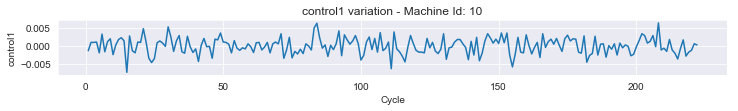

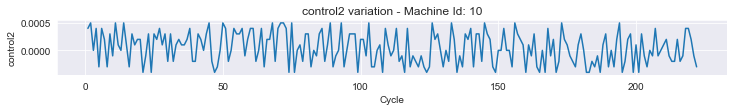

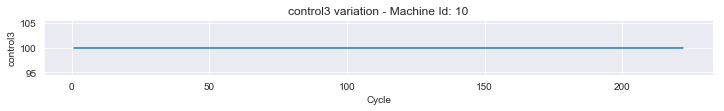

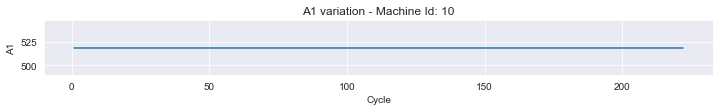

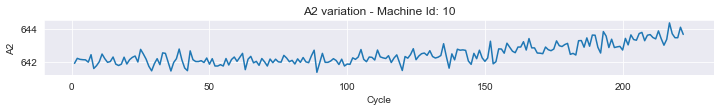

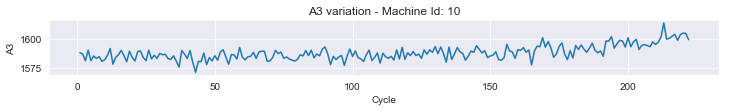

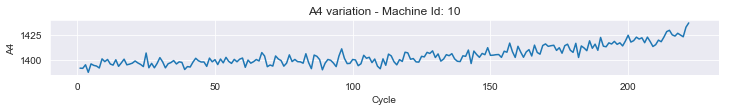

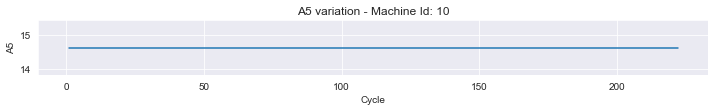

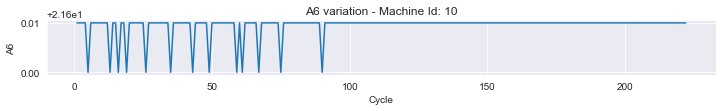

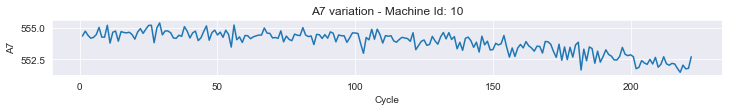

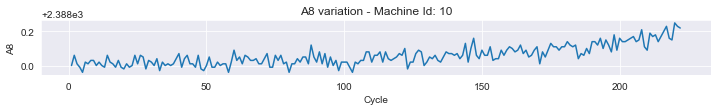

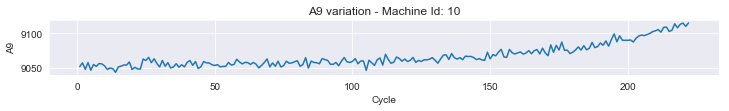

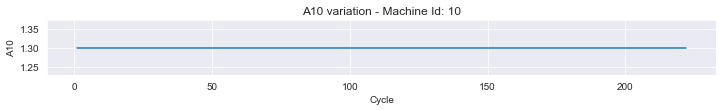

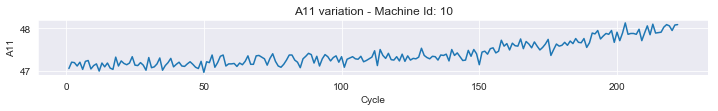

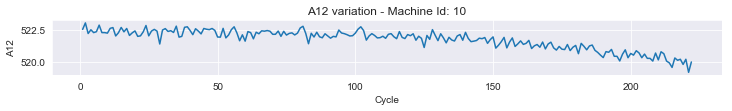

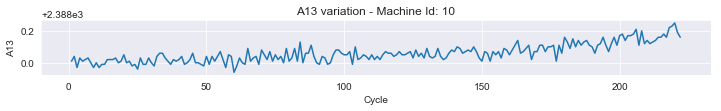

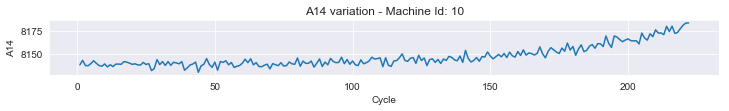

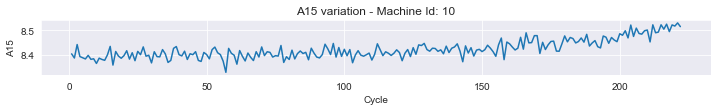

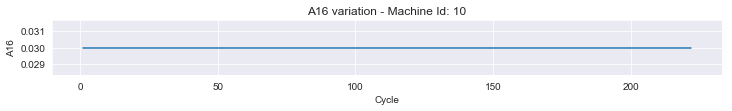

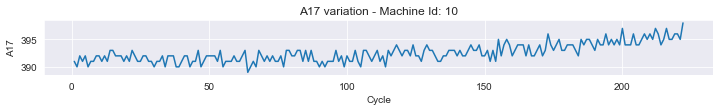

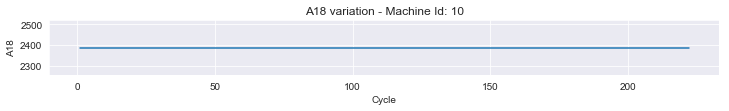

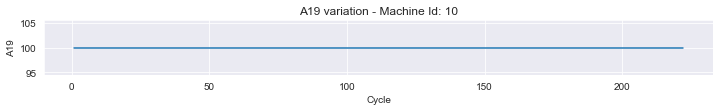

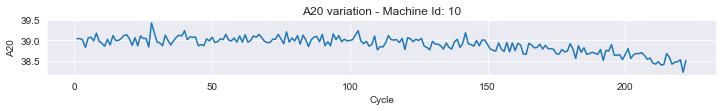

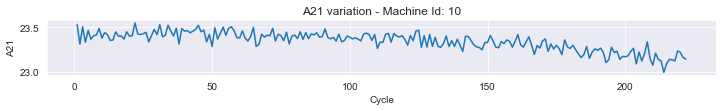

In [11]:
# We show an example graph of the collected measurments for machine Id 10 during Training phase.

machine_id = 10
cols = [ c for c in dataset_train.columns if c not in ['id','cycle'] ]
for i,col in enumerate(cols):
    plot_df = pd.DataFrame()
    temp = dataset_train.loc[(dataset_train["id"] == machine_id), ["cycle", col] ]
    plot_df = temp.set_index(temp.cycle).drop("cycle", axis=1)
    #print(plot_df.head())
    #print(plot_df.describe())

    plt.figure(figsize=(12, 1))
    plt.plot(plot_df[col])
    plt.title("{} variation - Machine Id: {}".format(col,machine_id) )
    plt.ylabel(col)

    plt.xlabel("Cycle")
    plt.show()

### Pairplots analysis

Checking possible statistical linkage between different variables ...

Let's start with ''setting1' and 'setting2'. We notice that 'setting3' is constant, as are 's1', 's5', 's10', 's16', 's18' and 's19'.

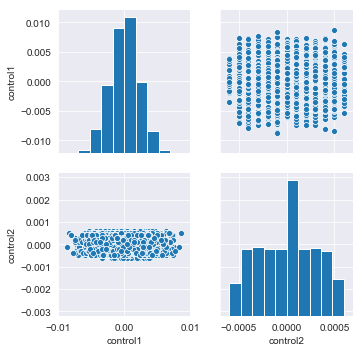

In [12]:
col = [ c for c in dataset_train.columns if str(c) not in ['id','cycle'] ]

sns.pairplot(dataset_train[col[:2] ])
#dataset_train[col].plot.scatter(col[0],col[1])

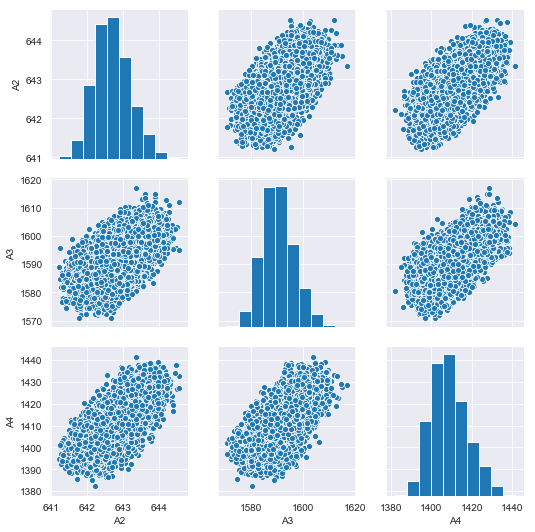

In [13]:
sns.pairplot(dataset_train[col[4:7] ])

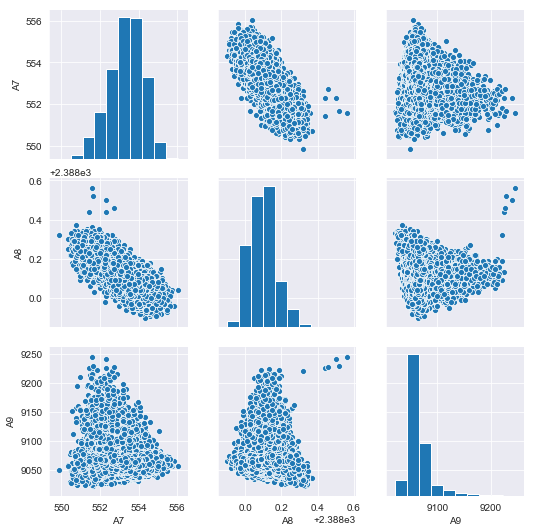

In [14]:
sns.pairplot(dataset_train[col[9:12] ])

We can notice almost a random distribution of pair-points amongst those selected variables, which allows us to presume a weak correlation between those pairs. A correlation calculation will allow us to understand better the statistitical independance between our feature variables. 

## Correlation analysis

Let's calculate cross-correlation matrix of our training dataset. 

In [15]:
colum = [ c for c in dataset_train.columns if c not in ['id','cycle'] ]
# Cross-correlation matrix calculation
corrs = dataset_train[colum].corr()
print("Cross-correlation matrix size:", corrs.shape)

Cross-correlation matrix size: (24, 24)


We identify pairs of variables with high correlation levels (>= 0.85 or < -0.85).

In [16]:
temp = np.where((np.triu(corrs) < -0.85) | (np.triu(corrs) > 0.85))  # extract indexes related to high correlations
temp = [sorted(a) for a in zip(temp[0], temp[1]) if a[0]!=a[1]]  # list of sorted 'tuples' of high correlations
print('\n Pair of features indices with the highest correlation factor: \n')
for k, idx in enumerate(temp):
    print('pair {}: index pair: {} / corr. coef = {:0.4f} / ({},{})' \
          .format(k+1, str(idx), corrs.iloc[temp[k][0], temp[k][1]], corrs.columns[temp[k][0]], corrs.columns[temp[k][1]] ) )


 Pair of features indices with the highest correlation factor: 

pair 1: index pair: [3, 7] / corr. coef = 1.0000 / (A1,A5)
pair 2: index pair: [3, 12] / corr. coef = 1.0000 / (A1,A10)
pair 3: index pair: [3, 18] / corr. coef = 1.0000 / (A1,A16)
pair 4: index pair: [7, 12] / corr. coef = 1.0000 / (A5,A10)
pair 5: index pair: [7, 18] / corr. coef = 1.0000 / (A5,A16)
pair 6: index pair: [11, 16] / corr. coef = 0.9632 / (A9,A14)
pair 7: index pair: [12, 18] / corr. coef = 1.0000 / (A10,A16)


#### Correlation heatmap

(24, 24)


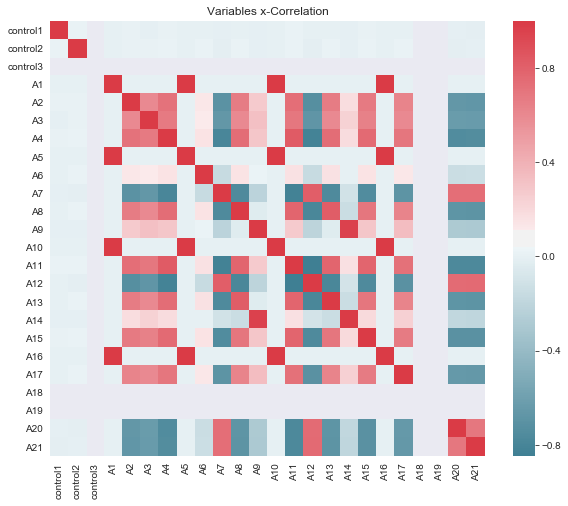

In [17]:
# It is necessary to eliminate the variables with high correlation (only one), consider> 70%.
f, ax = plt.subplots(figsize=(10, 8))
#corrs = dataset_train[cols].corr()
print(corrs.shape)
sns.heatmap(corrs, mask=np.zeros_like(corrs, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title("Variables x-Correlation")
plt.show()

It clearly appears that variables 'A1', 'A5', 'A10', 'A16', 'A18' are identical (corr. coef = 1.0 / constante function). On the other hand, 'A9' and 'A14' have a high coefficient of correlation of 0.96, which presumes both variables will carry out almost the same information !

We will have then to take such an information into account when constructing our final features matrix, by either running a PCA or 'feature importance' (tree-based or ensemble-based) analysis in order to select and retain only the set of variables that will bring valuable information to our predictive model. 

### Stationarity test

Likewise, some feature time-series show a certain 'trend' over time (increasing mean value), which makes us presume that they are not 'stationary'. We must run then, a 'stationarity' test to identify the non-stationary variables and apply to them appropriate transformations during features engineering phase of our data workflow.

We decided to use 'Augmented Dickey-Fuller unit root' test to accept/reject the null hypothesis of stationarity. The latter is well documented in the litterature. We will use python 'statsmodels' library for that purpose.

In [18]:
import statsmodels.tsa.stattools as tsa

In [19]:
# Augmented Dickey-Fuller unit root test used to check time-series stationarity

def ADFuller_test(df_in, verbose = True):
    
    cols = [ c for c in df_in.columns if c not in ['id','cycle', 'setting3', 's1','s5','s6', 's10','s16','s18','s19'] ]
    df_id_stationary = {}
    for c in cols:
        df2 = df_in[['id', 'cycle', c]].pivot_table(values=c, index='cycle', columns='id').reset_index(False)
        df_id = df2.drop('cycle',axis=1).fillna(0)
        temp = pd.DataFrame(np.zeros((len(df_id.columns),7),dtype='float'),dtype ='float', 
                                        columns=['id','stationarity', 'ADF_test','p_value','t_1','t_5','t_10'])
        temp['id'] = np.array(df_id.columns)
        
        adf_results = {}
        count = 0
        for row in df_id.columns.values:  #or edit this for a subset of columns first
            adf_results[row] = tsa.adfuller(df_id[row],maxlag=None, regression='ctt', autolag='BIC', store=False, regresults=False)
            d_order = adf_results[row]
            if verbose == True:
                print('id_{} / Feature_{} :'.format(row, c) )
                print('adf: ', d_order[0]) 
                print('p-value: ', d_order[1])
                print('Critical values: ', d_order[4])

            if d_order[0]> d_order[4]['1%']: 
                if verbose == True:
                    print('id_{} : Time Series {} is  nonstationary'.format(row,c))  
                temp.ix[count,'stationarity'] = 0
            else:
                if verbose == True:
                    print('id_{} : Time Series {} is stationary'.format(row,c))
                temp.ix[count,'stationarity'] = 1
            
            temp.ix[count,'ADF_test'] = d_order[0]
            temp.ix[count,'p_value']  = d_order[1]
            temp.ix[count,'t_1']      = d_order[4]['1%']
            temp.ix[count,'t_5']      = d_order[4]['5%']
            temp.ix[count,'t_10']     = d_order[4]['10%']
            count += 1

            temp.stationarity = temp.stationarity.astype('int')
            print()
            
        df_id_stationary[c] = temp
    
    return(df_id_stationary)

In [20]:
%%time

df_id_stationary = ADFuller_test(dataset_train, verbose = True)

id_1 / Feature_control1 :
adf:  -18.669531336494806
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_1 : Time Series control1 is stationary

id_2 / Feature_control1 :
adf:  -20.581315153112286
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_2 : Time Series control1 is stationary

id_3 / Feature_control1 :
adf:  -18.248489698557215
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_3 : Time Series control1 is stationary

id_4 / Feature_control1 :
adf:  -18.69662104124498
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_4 : Time Series control1 is stationary

id_5 / Feature_control1 :
adf:  -18.41455007473318
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_5 : Tim

id_42 / Feature_control1 :
adf:  -19.03582511140264
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_42 : Time Series control1 is stationary

id_43 / Feature_control1 :
adf:  -19.43733644633696
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_43 : Time Series control1 is stationary

id_44 / Feature_control1 :
adf:  -16.491318488620472
p-value:  8.968306583468148e-25
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_44 : Time Series control1 is stationary

id_45 / Feature_control1 :
adf:  -19.83941253193575
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_45 : Time Series control1 is stationary

id_46 / Feature_control1 :
adf:  -20.470815733400872
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.5

id_85 / Feature_control1 :
adf:  -18.743707854584617
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_85 : Time Series control1 is stationary

id_86 / Feature_control1 :
adf:  -18.45830931802298
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_86 : Time Series control1 is stationary

id_87 / Feature_control1 :
adf:  -15.00385236826896
p-value:  7.193106257354837e-24
Critical values:  {'1%': -4.403602985403807, '5%': -3.848893630915638, '10%': -3.56346775889489}
id_87 : Time Series control1 is stationary

id_88 / Feature_control1 :
adf:  -17.601685998565117
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_88 : Time Series control1 is stationary

id_89 / Feature_control1 :
adf:  -20.707938164171775
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.5

id_25 / Feature_control2 :
adf:  -18.696457165098096
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_25 : Time Series control2 is stationary

id_26 / Feature_control2 :
adf:  -22.61848681648741
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_26 : Time Series control2 is stationary

id_27 / Feature_control2 :
adf:  -18.296308638990723
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_27 : Time Series control2 is stationary

id_28 / Feature_control2 :
adf:  -16.986374696248404
p-value:  7.258094714693614e-25
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_28 : Time Series control2 is stationary

id_29 / Feature_control2 :
adf:  -19.745480399757007
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3

id_65 / Feature_control2 :
adf:  -12.707343952596359
p-value:  9.212256914504712e-21
Critical values:  {'1%': -4.403602985403807, '5%': -3.848893630915638, '10%': -3.56346775889489}
id_65 : Time Series control2 is stationary

id_66 / Feature_control2 :
adf:  -20.140928512350587
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_66 : Time Series control2 is stationary

id_67 / Feature_control2 :
adf:  -18.949194778929762
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_67 : Time Series control2 is stationary

id_68 / Feature_control2 :
adf:  -18.012925914291582
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_68 : Time Series control2 is stationary

id_69 / Feature_control2 :
adf:  -17.021609232150514
p-value:  7.216430011692652e-25
Critical values:  {'1%': -4.403512229555867, '5%': -3.84884763

id_5 / Feature_control3 :
adf:  -2.389801859794558
p-value:  0.631377108492917
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_5 : Time Series control3 is  nonstationary

id_6 / Feature_control3 :
adf:  -1.9402331635904324
p-value:  0.8386629078183184
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_6 : Time Series control3 is  nonstationary

id_7 / Feature_control3 :
adf:  -2.234923506653587
p-value:  0.7128644430906643
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_7 : Time Series control3 is  nonstationary

id_8 / Feature_control3 :
adf:  -2.316963318155012
p-value:  0.6707309989975685
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_8 : Time Series control3 is  nonstationary

id_9 / Feature_control3 :
adf:  -1.8708227443724108
p-value:  0.8617438398808623
Critical values:  {

id_47 / Feature_control3 :
adf:  -1.8493366703391823
p-value:  0.8683753811537318
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_47 : Time Series control3 is  nonstationary

id_48 / Feature_control3 :
adf:  -1.9095691628918392
p-value:  0.8491736280827594
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_48 : Time Series control3 is  nonstationary

id_49 / Feature_control3 :
adf:  -1.8499646977709707
p-value:  0.8681849490066401
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_49 : Time Series control3 is  nonstationary

id_50 / Feature_control3 :
adf:  -1.88297199210064
p-value:  0.857887344158366
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_50 : Time Series control3 is  nonstationary

id_51 / Feature_control3 :
adf:  -1.8490521209606479
p-value:  0.8684615957095867
Critical 

id_87 / Feature_control3 :
adf:  -2.0195618714234236
p-value:  0.809153347794014
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_87 : Time Series control3 is  nonstationary

id_88 / Feature_control3 :
adf:  -1.8490521209606479
p-value:  0.8684615957095867
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_88 : Time Series control3 is  nonstationary

id_89 / Feature_control3 :
adf:  -1.852267414112052
p-value:  0.8674849642284677
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_89 : Time Series control3 is  nonstationary

id_90 / Feature_control3 :
adf:  -2.270561813033439
p-value:  0.6948796328946013
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_90 : Time Series control3 is  nonstationary

id_91 / Feature_control3 :
adf:  -2.48940342218779
p-value:  0.5754161623109109
Critical va

id_28 / Feature_A1 :
adf:  -2.1476834029583785
p-value:  0.7545745643101008
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_28 : Time Series A1 is  nonstationary

id_29 / Feature_A1 :
adf:  -2.1692791786993
p-value:  0.744573220843374
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_29 : Time Series A1 is  nonstationary

id_30 / Feature_A1 :
adf:  -1.9029178674876717
p-value:  0.8513877215003425
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_30 : Time Series A1 is  nonstationary

id_31 / Feature_A1 :
adf:  -1.9315706371550005
p-value:  0.8416827580383013
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_31 : Time Series A1 is  nonstationary

id_32 / Feature_A1 :
adf:  -1.920517103316111
p-value:  0.8454782596906849
Critical values:  {'1%': -4.403512229555867, '5%': -3.84884763427

Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_70 : Time Series A1 is  nonstationary

id_71 / Feature_A1 :
adf:  -1.8526315063364522
p-value:  0.8673740349025472
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_71 : Time Series A1 is  nonstationary

id_72 / Feature_A1 :
adf:  -1.8490521209653892
p-value:  0.8684615957081505
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_72 : Time Series A1 is  nonstationary

id_73 / Feature_A1 :
adf:  -1.8490521209653892
p-value:  0.8684615957081505
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_73 : Time Series A1 is  nonstationary

id_74 / Feature_A1 :
adf:  -2.137043012768718
p-value:  0.7594204120042118
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_74 : Time Series A1 is  nonstationar

id_10 / Feature_A2 :
adf:  -1.8662030401842356
p-value:  0.8631899821391167
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_10 : Time Series A2 is  nonstationary

id_11 / Feature_A2 :
adf:  -1.9878067238889259
p-value:  0.8213668594250276
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_11 : Time Series A2 is  nonstationary

id_12 / Feature_A2 :
adf:  -2.0954976836745707
p-value:  0.7778093064545005
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_12 : Time Series A2 is  nonstationary

id_13 / Feature_A2 :
adf:  -2.172851842780211
p-value:  0.7428975135556866
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_13 : Time Series A2 is  nonstationary

id_14 / Feature_A2 :
adf:  -2.0023384485257645
p-value:  0.8158439333552235
Critical values:  {'1%': -4.403512229555867, '5%': -3.8488476

id_49 / Feature_A2 :
adf:  -1.8536052497281728
p-value:  0.8670770229121633
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_49 : Time Series A2 is  nonstationary

id_50 / Feature_A2 :
adf:  -1.8850779163719935
p-value:  0.857210992128931
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_50 : Time Series A2 is  nonstationary

id_51 / Feature_A2 :
adf:  -1.8534955665478248
p-value:  0.8671105031572632
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_51 : Time Series A2 is  nonstationary

id_52 / Feature_A2 :
adf:  -1.850258222499082
p-value:  0.8680958755777339
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_52 : Time Series A2 is  nonstationary

id_53 / Feature_A2 :
adf:  -1.900534836626899
p-value:  0.8521752983376445
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634

id_89 / Feature_A2 :
adf:  -1.852204360395044
p-value:  0.8675041680516267
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_89 : Time Series A2 is  nonstationary

id_90 / Feature_A2 :
adf:  -2.2710469681443364
p-value:  0.6946313054615281
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_90 : Time Series A2 is  nonstationary

id_91 / Feature_A2 :
adf:  -2.4891262874404037
p-value:  0.5755743336587482
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_91 : Time Series A2 is  nonstationary

id_92 / Feature_A2 :
adf:  -1.9491644071147207
p-value:  0.8355076071785839
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_92 : Time Series A2 is  nonstationary

id_93 / Feature_A2 :
adf:  -2.258197778708941
p-value:  0.7011770494185591
Critical values:  {'1%': -4.403512229555867, '5%': -3.84884763

id_28 / Feature_A3 :
adf:  -2.153941978082326
p-value:  0.7516988797319428
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_28 : Time Series A3 is  nonstationary

id_29 / Feature_A3 :
adf:  -2.1684803501259986
p-value:  0.7449470860361364
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_29 : Time Series A3 is  nonstationary

id_30 / Feature_A3 :
adf:  -1.9135798029002264
p-value:  0.8478272467504846
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_30 : Time Series A3 is  nonstationary

id_31 / Feature_A3 :
adf:  -1.9421961787064166
p-value:  0.8379730355840255
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_31 : Time Series A3 is  nonstationary

id_32 / Feature_A3 :
adf:  -1.9312466859951163
p-value:  0.8417949174049946
Critical values:  {'1%': -4.403512229555867, '5%': -3.8488476

id_68 / Feature_A3 :
adf:  -1.8952529452976241
p-value:  0.8539102432893424
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_68 : Time Series A3 is  nonstationary

id_69 / Feature_A3 :
adf:  -17.85165808893408
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_69 : Time Series A3 is stationary

id_70 / Feature_A3 :
adf:  -2.47113471228608
p-value:  0.5858191553328241
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_70 : Time Series A3 is  nonstationary

id_71 / Feature_A3 :
adf:  -1.8614729376955947
p-value:  0.8646591411225804
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_71 : Time Series A3 is  nonstationary

id_72 / Feature_A3 :
adf:  -1.8553727350309794
p-value:  0.8665366454666766
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.5

id_7 / Feature_A4 :
adf:  -2.2679062547966025
p-value:  0.6962372624165616
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_7 : Time Series A4 is  nonstationary

id_8 / Feature_A4 :
adf:  -2.3277586571298037
p-value:  0.6650032183491659
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_8 : Time Series A4 is  nonstationary

id_9 / Feature_A4 :
adf:  -1.8957785240101146
p-value:  0.8537382657081921
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_9 : Time Series A4 is  nonstationary

id_10 / Feature_A4 :
adf:  -1.9012440309491623
p-value:  0.8519412275640441
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_10 : Time Series A4 is  nonstationary

id_11 / Feature_A4 :
adf:  -2.021695418293813
p-value:  0.8083136636935186
Critical values:  {'1%': -4.403512229555867, '5%': -3.8488476342762


id_48 / Feature_A4 :
adf:  -1.9522074293577762
p-value:  0.8344228532257539
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_48 : Time Series A4 is  nonstationary

id_49 / Feature_A4 :
adf:  -1.8714485142583004
p-value:  0.8615470923909215
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_49 : Time Series A4 is  nonstationary

id_50 / Feature_A4 :
adf:  -1.9051372631079833
p-value:  0.8506515263474315
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_50 : Time Series A4 is  nonstationary

id_51 / Feature_A4 :
adf:  -1.874219761122836
p-value:  0.8606733254689696
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_51 : Time Series A4 is  nonstationary

id_52 / Feature_A4 :
adf:  -1.876719088681831
p-value:  0.8598818451851604
Critical values:  {'1%': -4.403512229555867, '5%': -3.8488476

id_87 / Feature_A4 :
adf:  -2.0346013065075876
p-value:  0.8031833939385522
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_87 : Time Series A4 is  nonstationary

id_88 / Feature_A4 :
adf:  -1.870590675976416
p-value:  0.8618167521444161
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_88 : Time Series A4 is  nonstationary

id_89 / Feature_A4 :
adf:  -1.8758401406892202
p-value:  0.8601605611411427
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_89 : Time Series A4 is  nonstationary

id_90 / Feature_A4 :
adf:  -2.292433846062883
p-value:  0.6835951880884067
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_90 : Time Series A4 is  nonstationary

id_91 / Feature_A4 :
adf:  -2.4948644860713047
p-value:  0.5722972339525854
Critical values:  {'1%': -4.403512229555867, '5%': -3.84884763

adf:  -1.9030067630955714
p-value:  0.8513582840096028
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_25 : Time Series A5 is  nonstationary

id_26 / Feature_A5 :
adf:  -1.8786465054590846
p-value:  0.8592692402272598
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_26 : Time Series A5 is  nonstationary

id_27 / Feature_A5 :
adf:  -2.247595210638738
p-value:  0.7065287205200784
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_27 : Time Series A5 is  nonstationary

id_28 / Feature_A5 :
adf:  -2.1476834029583793
p-value:  0.7545745643101004
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_28 : Time Series A5 is  nonstationary

id_29 / Feature_A5 :
adf:  -2.169279178699642
p-value:  0.7445732208432139
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.56

id_66 / Feature_A5 :
adf:  -1.8673341636810774
p-value:  0.8628369283484647
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_66 : Time Series A5 is  nonstationary

id_67 / Feature_A5 :
adf:  -2.602663713687638
p-value:  0.5102265981476378
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_67 : Time Series A5 is  nonstationary

id_68 / Feature_A5 :
adf:  -1.8786465054590846
p-value:  0.8592692402272598
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_68 : Time Series A5 is  nonstationary

id_69 / Feature_A5 :
adf:  nan
p-value:  nan
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_69 : Time Series A5 is stationary

id_70 / Feature_A5 :
adf:  -2.4671431496477623
p-value:  0.5880853005059334
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767

id_9 / Feature_A6 :
adf:  -1.8708368119508947
p-value:  0.8617394191621851
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_9 : Time Series A6 is  nonstationary

id_10 / Feature_A6 :
adf:  -1.8642429568842918
p-value:  0.8638001952219774
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_10 : Time Series A6 is  nonstationary

id_11 / Feature_A6 :
adf:  -1.9858551898887602
p-value:  0.8221000304602224
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_11 : Time Series A6 is  nonstationary

id_12 / Feature_A6 :
adf:  -2.0956540734106173
p-value:  0.7777416987520278
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_12 : Time Series A6 is  nonstationary

id_13 / Feature_A6 :
adf:  -2.169279178699301
p-value:  0.7445732208433736
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634

id_50 / Feature_A6 :
adf:  -1.8829623619569142
p-value:  0.8578904316843339
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_50 : Time Series A6 is  nonstationary

id_51 / Feature_A6 :
adf:  -1.8490326902650813
p-value:  0.8684674814138914
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_51 : Time Series A6 is  nonstationary

id_52 / Feature_A6 :
adf:  -1.8490397379564996
p-value:  0.8684653466375827
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_52 : Time Series A6 is  nonstationary

id_53 / Feature_A6 :
adf:  -1.897519052113085
p-value:  0.8531676974483351
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_53 : Time Series A6 is  nonstationary

id_54 / Feature_A6 :
adf:  -2.2046560602535448
p-value:  0.7277223728613877
Critical values:  {'1%': -4.403512229555867, '5%': -3.8488476

id_90 / Feature_A6 :
adf:  -2.270524180203506
p-value:  0.6948988915009108
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_90 : Time Series A6 is  nonstationary

id_91 / Feature_A6 :
adf:  -2.489403422187789
p-value:  0.5754161623109115
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_91 : Time Series A6 is  nonstationary

id_92 / Feature_A6 :
adf:  -1.9466043230930101
p-value:  0.8364163915594947
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_92 : Time Series A6 is  nonstationary

id_93 / Feature_A6 :
adf:  -2.2590217751799977
p-value:  0.7007592411491806
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_93 : Time Series A6 is  nonstationary

id_94 / Feature_A6 :
adf:  -2.2197096315618734
p-value:  0.7203821452135909
Critical values:  {'1%': -4.403512229555867, '5%': -3.84884763

id_36 / Feature_A7 :
adf:  -2.2256408802029504
p-value:  0.7174630337680923
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_36 : Time Series A7 is  nonstationary

id_37 / Feature_A7 :
adf:  -2.0953334097398053
p-value:  0.7778803092244175
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_37 : Time Series A7 is  nonstationary

id_38 / Feature_A7 :
adf:  -1.9007198194893449
p-value:  0.8521142700407491
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_38 : Time Series A7 is  nonstationary

id_39 / Feature_A7 :
adf:  -2.5617812774805615
p-value:  0.5338349782323945
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_39 : Time Series A7 is  nonstationary

id_40 / Feature_A7 :
adf:  -1.937996782272431
p-value:  0.8394463538340944
Critical values:  {'1%': -4.403512229555867, '5%': -3.8488476

id_75 / Feature_A7 :
adf:  -1.8977153791571324
p-value:  0.8531032385228514
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_75 : Time Series A7 is  nonstationary

id_76 / Feature_A7 :
adf:  -1.845788404706247
p-value:  0.8694474592780219
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_76 : Time Series A7 is  nonstationary

id_77 / Feature_A7 :
adf:  -2.270832298955313
p-value:  0.6947411955036074
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_77 : Time Series A7 is  nonstationary

id_78 / Feature_A7 :
adf:  -1.9054077687609532
p-value:  0.8505616189643159
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_78 : Time Series A7 is  nonstationary

id_79 / Feature_A7 :
adf:  -1.8740112548289123
p-value:  0.8607392068108254
Critical values:  {'1%': -4.403512229555867, '5%': -3.84884763

id_21 / Feature_A8 :
adf:  -1.8976002900992568
p-value:  0.8531410275158959
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_21 : Time Series A8 is  nonstationary

id_22 / Feature_A8 :
adf:  -1.867395513580164
p-value:  0.8628177603102608
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_22 : Time Series A8 is  nonstationary

id_23 / Feature_A8 :
adf:  -2.116089996713208
p-value:  0.7688016081993272
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_23 : Time Series A8 is  nonstationary

id_24 / Feature_A8 :
adf:  -2.351972864648807
p-value:  0.6520171010449975
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_24 : Time Series A8 is  nonstationary

id_25 / Feature_A8 :
adf:  -1.9030093712300171
p-value:  0.8513574202713288
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634

id_60 / Feature_A8 :
adf:  -2.075730435129534
p-value:  0.7862548603115016
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_60 : Time Series A8 is  nonstationary

id_61 / Feature_A8 :
adf:  -1.96196661771768
p-value:  0.8309107358006774
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_61 : Time Series A8 is  nonstationary

id_62 / Feature_A8 :
adf:  -2.0021945837319257
p-value:  0.8158991588152972
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_62 : Time Series A8 is  nonstationary

id_63 / Feature_A8 :
adf:  -2.0564214134195624
p-value:  0.7943115196019459
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_63 : Time Series A8 is  nonstationary

id_64 / Feature_A8 :
adf:  -2.578260113812081
p-value:  0.5243213926485375
Critical values:  {'1%': -4.403512229555867, '5%': -3.8488476342

id_1 / Feature_A9 :
adf:  -1.9123710960932623
p-value:  0.8482339091327519
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_1 : Time Series A9 is  nonstationary

id_2 / Feature_A9 :
adf:  -2.6219553871704853
p-value:  0.49909065852193873
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_2 : Time Series A9 is  nonstationary

id_3 / Feature_A9 :
adf:  -2.0217374090566134
p-value:  0.8082971136642916
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_3 : Time Series A9 is  nonstationary

id_4 / Feature_A9 :
adf:  -1.9467507893949776
p-value:  0.8363644926440449
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_4 : Time Series A9 is  nonstationary

id_5 / Feature_A9 :
adf:  -2.3995868157992395
p-value:  0.6259747736932157
Critical values:  {'1%': -4.403512229555867, '5%': -3.84884763427620

id_43 / Feature_A9 :
adf:  -1.8515849479538902
p-value:  0.8676927084694275
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_43 : Time Series A9 is  nonstationary

id_44 / Feature_A9 :
adf:  -1.9150073552517441
p-value:  0.8473459583029406
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_44 : Time Series A9 is  nonstationary

id_45 / Feature_A9 :
adf:  -2.2262197384785076
p-value:  0.7171773372588313
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_45 : Time Series A9 is  nonstationary

id_46 / Feature_A9 :
adf:  -2.185946998528117
p-value:  0.7367049464715648
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_46 : Time Series A9 is  nonstationary

id_47 / Feature_A9 :
adf:  -1.8538307189207253
p-value:  0.8670081799497976
Critical values:  {'1%': -4.403512229555867, '5%': -3.8488476

id_87 / Feature_A9 :
adf:  -2.019056141507656
p-value:  0.8093520328033612
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_87 : Time Series A9 is  nonstationary

id_88 / Feature_A9 :
adf:  -1.8583531334656758
p-value:  0.8656217648595641
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_88 : Time Series A9 is  nonstationary

id_89 / Feature_A9 :
adf:  -1.855837265024373
p-value:  0.8663943543468331
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_89 : Time Series A9 is  nonstationary

id_90 / Feature_A9 :
adf:  -2.2686390318036818
p-value:  0.6958629115431186
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_90 : Time Series A9 is  nonstationary

id_91 / Feature_A9 :
adf:  -2.4892862372610884
p-value:  0.575483045482577
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634

Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_28 : Time Series A10 is  nonstationary

id_29 / Feature_A10 :
adf:  -2.1692791786993015
p-value:  0.7445732208433734
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_29 : Time Series A10 is  nonstationary

id_30 / Feature_A10 :
adf:  -1.9029178674876759
p-value:  0.8513877215003411
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_30 : Time Series A10 is  nonstationary

id_31 / Feature_A10 :
adf:  -1.9315706371550325
p-value:  0.8416827580382902
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_31 : Time Series A10 is  nonstationary

id_32 / Feature_A10 :
adf:  -1.9205171033160033
p-value:  0.8454782596907218
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_32 : Time Series A10 is  no

id_70 / Feature_A10 :
adf:  -2.467143149647762
p-value:  0.5880853005059336
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_70 : Time Series A10 is  nonstationary

id_71 / Feature_A10 :
adf:  -1.8526315063407062
p-value:  0.8673740349012508
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_71 : Time Series A10 is  nonstationary

id_72 / Feature_A10 :
adf:  -1.849052120965404
p-value:  0.8684615957081461
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_72 : Time Series A10 is  nonstationary

id_73 / Feature_A10 :
adf:  -1.849052120965404
p-value:  0.8684615957081461
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_73 : Time Series A10 is  nonstationary

id_74 / Feature_A10 :
adf:  -2.1370430127687037
p-value:  0.7594204120042185
Critical values:  {'1%': -4.403512229555867, '5%': -3.

id_9 / Feature_A11 :
adf:  -1.8933220264543664
p-value:  0.8545408196938329
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_9 : Time Series A11 is  nonstationary

id_10 / Feature_A11 :
adf:  -1.881462207027588
p-value:  0.8583708024550376
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_10 : Time Series A11 is  nonstationary

id_11 / Feature_A11 :
adf:  -2.0105057537624424
p-value:  0.8126907984577367
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_11 : Time Series A11 is  nonstationary

id_12 / Feature_A11 :
adf:  -2.0963423293614927
p-value:  0.7774440171996277
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_12 : Time Series A11 is  nonstationary

id_13 / Feature_A11 :
adf:  -2.181810084320189
p-value:  0.7386697704627014
Critical values:  {'1%': -4.403512229555867, '5%': -3.8

id_48 / Feature_A11 :
adf:  -1.929588140274845
p-value:  0.8423682709072601
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_48 : Time Series A11 is  nonstationary

id_49 / Feature_A11 :
adf:  -1.8664470054833535
p-value:  0.8631138905650495
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_49 : Time Series A11 is  nonstationary

id_50 / Feature_A11 :
adf:  -1.8888072314203115
p-value:  0.8560075409308876
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_50 : Time Series A11 is  nonstationary

id_51 / Feature_A11 :
adf:  -1.8614167370042658
p-value:  0.8646765268178973
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_51 : Time Series A11 is  nonstationary

id_52 / Feature_A11 :
adf:  -1.8618290475181616
p-value:  0.8645489402311115
Critical values:  {'1%': -4.403512229555867, '5%': -

id_88 / Feature_A11 :
adf:  -1.8781974741855811
p-value:  0.8594121331603779
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_88 : Time Series A11 is  nonstationary

id_89 / Feature_A11 :
adf:  -1.8832505028379352
p-value:  0.8577980295910272
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_89 : Time Series A11 is  nonstationary

id_90 / Feature_A11 :
adf:  -2.2909954363025613
p-value:  0.6843428202721002
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_90 : Time Series A11 is  nonstationary

id_91 / Feature_A11 :
adf:  -2.494750287091402
p-value:  0.5723624953809879
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_91 : Time Series A11 is  nonstationary

id_92 / Feature_A11 :
adf:  -1.944216882599805
p-value:  0.8372607491378672
Critical values:  {'1%': -4.403512229555867, '5%': -3

adf:  -1.8731867265177977
p-value:  0.8609995084967358
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_26 : Time Series A12 is  nonstationary

id_27 / Feature_A12 :
adf:  -2.2462745269811797
p-value:  0.7071921418281392
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_27 : Time Series A12 is  nonstationary

id_28 / Feature_A12 :
adf:  -2.1432658503746227
p-value:  0.7565930365207318
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_28 : Time Series A12 is  nonstationary

id_29 / Feature_A12 :
adf:  -2.1684120602293233
p-value:  0.744979033024645
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_29 : Time Series A12 is  nonstationary

id_30 / Feature_A12 :
adf:  -1.8979423374690527
p-value:  0.8530286972626886
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10

id_65 / Feature_A12 :
adf:  -2.281723084235008
p-value:  0.6891437935888908
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_65 : Time Series A12 is  nonstationary

id_66 / Feature_A12 :
adf:  -1.8646910713367937
p-value:  0.8636608649860104
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_66 : Time Series A12 is  nonstationary

id_67 / Feature_A12 :
adf:  -2.6066118335254083
p-value:  0.5079467374308919
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_67 : Time Series A12 is  nonstationary

id_68 / Feature_A12 :
adf:  -1.875294437153042
p-value:  0.86033340101147
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_68 : Time Series A12 is  nonstationary

id_69 / Feature_A12 :
adf:  -17.863299950890518
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208,

Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_4 : Time Series A13 is  nonstationary

id_5 / Feature_A13 :
adf:  -2.389845469130884
p-value:  0.6313530862872666
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_5 : Time Series A13 is  nonstationary

id_6 / Feature_A13 :
adf:  -1.9402918664924416
p-value:  0.8386423072836862
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_6 : Time Series A13 is  nonstationary

id_7 / Feature_A13 :
adf:  -2.235000296901939
p-value:  0.7128262498152345
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_7 : Time Series A13 is  nonstationary

id_8 / Feature_A13 :
adf:  -2.3169610003763843
p-value:  0.6707322245166155
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_8 : Time Series A13 is  nonstationary

id_45 / Feature_A13 :
adf:  -2.2249098149174604
p-value:  0.717823647945431
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_45 : Time Series A13 is  nonstationary

id_46 / Feature_A13 :
adf:  -2.18986575836149
p-value:  0.7348365376384357
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_46 : Time Series A13 is  nonstationary

id_47 / Feature_A13 :
adf:  -1.8494216468856277
p-value:  0.868349626293502
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_47 : Time Series A13 is  nonstationary

id_48 / Feature_A13 :
adf:  -1.9100842501829407
p-value:  0.8490011886790751
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_48 : Time Series A13 is  nonstationary

id_49 / Feature_A13 :
adf:  -1.8500478410865244
p-value:  0.8681597227508704
Critical values:  {'1%': -4.403512229555867, '5%': -3.8

id_85 / Feature_A13 :
adf:  -1.940305510463954
p-value:  0.8386375189597228
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_85 : Time Series A13 is  nonstationary

id_86 / Feature_A13 :
adf:  -2.5186917495932066
p-value:  0.5586469913380655
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_86 : Time Series A13 is  nonstationary

id_87 / Feature_A13 :
adf:  -2.0196260866981395
p-value:  0.8091281100432022
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_87 : Time Series A13 is  nonstationary

id_88 / Feature_A13 :
adf:  -1.8491238877555862
p-value:  0.8684398553108499
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_88 : Time Series A13 is  nonstationary

id_89 / Feature_A13 :
adf:  -1.8523182196178636
p-value:  0.8674694892556565
Critical values:  {'1%': -4.403512229555867, '5%': -

id_26 / Feature_A14 :
adf:  -1.888761721470962
p-value:  0.8560222711062175
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_26 : Time Series A14 is  nonstationary

id_27 / Feature_A14 :
adf:  -2.2524672744959227
p-value:  0.7040751780555526
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_27 : Time Series A14 is  nonstationary

id_28 / Feature_A14 :
adf:  -2.149992086847089
p-value:  0.7535159515997671
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_28 : Time Series A14 is  nonstationary

id_29 / Feature_A14 :
adf:  -2.1673177989052275
p-value:  0.7454906467124269
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_29 : Time Series A14 is  nonstationary

id_30 / Feature_A14 :
adf:  -1.8992436619798643
p-value:  0.8526007707414746
Critical values:  {'1%': -4.403512229555867, '5%': -3

id_69 / Feature_A14 :
adf:  -18.311518787447753
p-value:  0.0
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_69 : Time Series A14 is stationary

id_70 / Feature_A14 :
adf:  -2.470173638709866
p-value:  0.5863650252174037
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_70 : Time Series A14 is  nonstationary

id_71 / Feature_A14 :
adf:  -1.864358539733547
p-value:  0.8637642675838093
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_71 : Time Series A14 is  nonstationary

id_72 / Feature_A14 :
adf:  -1.8457521513915303
p-value:  0.8694583792872146
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_72 : Time Series A14 is  nonstationary

id_73 / Feature_A14 :
adf:  -1.8483883798478362
p-value:  0.8686625371594769
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '

id_9 / Feature_A15 :
adf:  -1.8858656373110436
p-value:  0.8569574036506165
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_9 : Time Series A15 is  nonstationary

id_10 / Feature_A15 :
adf:  -1.8798441707064555
p-value:  0.858887596067573
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_10 : Time Series A15 is  nonstationary

id_11 / Feature_A15 :
adf:  -2.0006948959452906
p-value:  0.8164741926151609
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_11 : Time Series A15 is  nonstationary

id_12 / Feature_A15 :
adf:  -2.1019860638606014
p-value:  0.7749940132855104
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_12 : Time Series A15 is  nonstationary

id_13 / Feature_A15 :
adf:  -2.1794780745493996
p-value:  0.739773899770628
Critical values:  {'1%': -4.403512229555867, '5%': -3.8

id_51 / Feature_A15 :
adf:  -1.869145045923369
p-value:  0.8622703125082899
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_51 : Time Series A15 is  nonstationary

id_52 / Feature_A15 :
adf:  -1.8595231206473046
p-value:  0.8652613560114693
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_52 : Time Series A15 is  nonstationary

id_53 / Feature_A15 :
adf:  -1.9070455835591518
p-value:  0.8500164356023703
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_53 : Time Series A15 is  nonstationary

id_54 / Feature_A15 :
adf:  -2.2245110293718273
p-value:  0.718020261510748
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_54 : Time Series A15 is  nonstationary

id_55 / Feature_A15 :
adf:  -1.9223942554154825
p-value:  0.8448382647469512
Critical values:  {'1%': -4.403512229555867, '5%': -3

id_90 / Feature_A15 :
adf:  -2.282529911685144
p-value:  0.6887273199960897
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_90 : Time Series A15 is  nonstationary

id_91 / Feature_A15 :
adf:  -2.4950119199388245
p-value:  0.5722129772645798
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_91 : Time Series A15 is  nonstationary

id_92 / Feature_A15 :
adf:  -1.958518727995038
p-value:  0.8321573440513123
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_92 : Time Series A15 is  nonstationary

id_93 / Feature_A15 :
adf:  -2.253369594703442
p-value:  0.7036197181688986
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_93 : Time Series A15 is  nonstationary

id_94 / Feature_A15 :
adf:  -2.235635585951764
p-value:  0.7125101804024899
Critical values:  {'1%': -4.403512229555867, '5%': -3.8


id_31 / Feature_A16 :
adf:  -1.9315706371550332
p-value:  0.84168275803829
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_31 : Time Series A16 is  nonstationary

id_32 / Feature_A16 :
adf:  -1.9205171033160036
p-value:  0.8454782596907215
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_32 : Time Series A16 is  nonstationary

id_33 / Feature_A16 :
adf:  -1.8745951387491517
p-value:  0.8605546607194969
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_33 : Time Series A16 is  nonstationary

id_34 / Feature_A16 :
adf:  -1.8975445448015962
p-value:  0.8531593287300369
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_34 : Time Series A16 is  nonstationary

id_35 / Feature_A16 :
adf:  -1.9937342861345422
p-value:  0.8191275464140815
Critical values:  {'1%': -4.403512229555867, '5%': -

adf:  -1.8490521209606858
p-value:  0.8684615957095752
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_72 : Time Series A16 is  nonstationary

id_73 / Feature_A16 :
adf:  -1.8490521209606858
p-value:  0.8684615957095752
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_73 : Time Series A16 is  nonstationary

id_74 / Feature_A16 :
adf:  -2.137043012768719
p-value:  0.7594204120042114
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_74 : Time Series A16 is  nonstationary

id_75 / Feature_A16 :
adf:  -1.8968301689660623
p-value:  0.8533937135979891
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_75 : Time Series A16 is  nonstationary

id_76 / Feature_A16 :
adf:  -1.8502169101475292
p-value:  0.868108414982196
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%

id_13 / Feature_A17 :
adf:  -2.1795662459753604
p-value:  0.7397321989982094
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_13 : Time Series A17 is  nonstationary

id_14 / Feature_A17 :
adf:  -2.0143893919878253
p-value:  0.8111790896616595
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_14 : Time Series A17 is  nonstationary

id_15 / Feature_A17 :
adf:  -1.8641321773181747
p-value:  0.8638346232739248
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_15 : Time Series A17 is  nonstationary

id_16 / Feature_A17 :
adf:  -1.8639330066256172
p-value:  0.8638965054054271
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_16 : Time Series A17 is  nonstationary

id_17 / Feature_A17 :
adf:  -2.5050275094939747
p-value:  0.5664828801073922
Critical values:  {'1%': -4.403512229555867, '5%': 

id_55 / Feature_A17 :
adf:  -1.9197571710658055
p-value:  0.8457368189827836
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_55 : Time Series A17 is  nonstationary

id_56 / Feature_A17 :
adf:  -2.476847851887769
p-value:  0.5825712027122962
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_56 : Time Series A17 is  nonstationary

id_57 / Feature_A17 :
adf:  -2.4682647174819974
p-value:  0.5874488105423357
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_57 : Time Series A17 is  nonstationary

id_58 / Feature_A17 :
adf:  -2.3533827835299554
p-value:  0.6512552913028522
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_58 : Time Series A17 is  nonstationary

id_59 / Feature_A17 :
adf:  -1.9154201191559126
p-value:  0.8472065968544638
Critical values:  {'1%': -4.403512229555867, '5%': -

id_96 / Feature_A17 :
adf:  -2.1373612792744394
p-value:  0.7592762611014214
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_96 : Time Series A17 is  nonstationary

id_97 / Feature_A17 :
adf:  -1.8835743246192709
p-value:  0.8576941331601035
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_97 : Time Series A17 is  nonstationary

id_98 / Feature_A17 :
adf:  -2.250884405949831
p-value:  0.704873359105013
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_98 : Time Series A17 is  nonstationary

id_99 / Feature_A17 :
adf:  -1.974994787546396
p-value:  0.8261432245657321
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_99 : Time Series A17 is  nonstationary

id_100 / Feature_A17 :
adf:  -1.879897623986575
p-value:  0.8588705452736112
Critical values:  {'1%': -4.403512229555867, '5%': -3.

id_37 / Feature_A18 :
adf:  -2.0956540734107354
p-value:  0.7777416987519767
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_37 : Time Series A18 is  nonstationary

id_38 / Feature_A18 :
adf:  -1.9029178674876808
p-value:  0.8513877215003395
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_38 : Time Series A18 is  nonstationary

id_39 / Feature_A18 :
adf:  -2.563376288529429
p-value:  0.5329145002566951
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_39 : Time Series A18 is  nonstationary

id_40 / Feature_A18 :
adf:  -1.9402331635904535
p-value:  0.838662907818311
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_40 : Time Series A18 is  nonstationary

id_41 / Feature_A18 :
adf:  -1.8509402901651644
p-value:  0.8678887219182012
Critical values:  {'1%': -4.403512229555867, '5%': -3

id_78 / Feature_A18 :
adf:  -1.909569162891887
p-value:  0.8491736280827433
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_78 : Time Series A18 is  nonstationary

id_79 / Feature_A18 :
adf:  -1.878646505459086
p-value:  0.8592692402272593
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_79 : Time Series A18 is  nonstationary

id_80 / Feature_A18 :
adf:  -1.961935086552925
p-value:  0.8309221647638991
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_80 : Time Series A18 is  nonstationary

id_81 / Feature_A18 :
adf:  -1.9858646917205047
p-value:  0.8220964656180685
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_81 : Time Series A18 is  nonstationary

id_82 / Feature_A18 :
adf:  -1.8493366703392093
p-value:  0.8683753811537236
Critical values:  {'1%': -4.403512229555867, '5%': -3.

id_19 / Feature_A19 :
adf:  -2.2248516829227785
p-value:  0.7178523130431288
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_19 : Time Series A19 is  nonstationary

id_20 / Feature_A19 :
adf:  -1.9315706371549506
p-value:  0.8416827580383186
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_20 : Time Series A19 is  nonstationary

id_21 / Feature_A19 :
adf:  -1.897544544801577
p-value:  0.8531593287300432
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_21 : Time Series A19 is  nonstationary

id_22 / Feature_A19 :
adf:  -1.8673341636810556
p-value:  0.8628369283484716
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_22 : Time Series A19 is  nonstationary

id_23 / Feature_A19 :
adf:  -2.116103645024622
p-value:  0.7687955678683894
Critical values:  {'1%': -4.403512229555867, '5%': -3

id_60 / Feature_A19 :
adf:  -2.0757351368220562
p-value:  0.7862528751935832
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_60 : Time Series A19 is  nonstationary

id_61 / Feature_A19 :
adf:  -1.9619350865529028
p-value:  0.8309221647639073
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_61 : Time Series A19 is  nonstationary

id_62 / Feature_A19 :
adf:  -2.002163152497282
p-value:  0.8159112228834384
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_62 : Time Series A19 is  nonstationary

id_63 / Feature_A19 :
adf:  -2.0563870474707353
p-value:  0.7943256871804958
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_63 : Time Series A19 is  nonstationary

id_64 / Feature_A19 :
adf:  -2.5782886695429124
p-value:  0.5243049013371034
Critical values:  {'1%': -4.403512229555867, '5%': -

id_99 / Feature_A19 :
adf:  -1.9619350865529028
p-value:  0.8309221647639073
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_99 : Time Series A19 is  nonstationary

id_100 / Feature_A19 :
adf:  -1.8745951387491318
p-value:  0.8605546607195034
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_100 : Time Series A19 is  nonstationary

id_1 / Feature_A20 :
adf:  -1.9087928870312982
p-value:  0.8494332421557349
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_1 : Time Series A20 is  nonstationary

id_2 / Feature_A20 :
adf:  -2.6160869528051722
p-value:  0.5024768905424549
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_2 : Time Series A20 is  nonstationary

id_3 / Feature_A20 :
adf:  -2.002390831203017
p-value:  0.8158238224674071
Critical values:  {'1%': -4.403512229555867, '5%': -3.8

id_38 / Feature_A20 :
adf:  -1.8916616513016675
p-value:  0.8550814738192084
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_38 : Time Series A20 is  nonstationary

id_39 / Feature_A20 :
adf:  -2.562134513645793
p-value:  0.5336311344685767
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_39 : Time Series A20 is  nonstationary

id_40 / Feature_A20 :
adf:  -1.9381969410630047
p-value:  0.839376342821252
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_40 : Time Series A20 is  nonstationary

id_41 / Feature_A20 :
adf:  -1.8294917296679554
p-value:  0.8742879234505436
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_41 : Time Series A20 is  nonstationary

id_42 / Feature_A20 :
adf:  -1.8900846612985276
p-value:  0.8555936312691175
Critical values:  {'1%': -4.403512229555867, '5%': -3

id_78 / Feature_A20 :
adf:  -1.8874281383774558
p-value:  0.8564534271684244
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_78 : Time Series A20 is  nonstationary

id_79 / Feature_A20 :
adf:  -1.8709027430019025
p-value:  0.8617186990339678
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_79 : Time Series A20 is  nonstationary

id_80 / Feature_A20 :
adf:  -1.9579092303061727
p-value:  0.8323770543143671
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_80 : Time Series A20 is  nonstationary

id_81 / Feature_A20 :
adf:  -1.9736469187225067
p-value:  0.826640647696097
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_81 : Time Series A20 is  nonstationary

id_82 / Feature_A20 :
adf:  -1.8457625376245115
p-value:  0.8694552508769664
Critical values:  {'1%': -4.403512229555867, '5%': -

id_17 / Feature_A21 :
adf:  -2.492331530904367
p-value:  0.5737443476068634
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_17 : Time Series A21 is  nonstationary

id_18 / Feature_A21 :
adf:  -1.8851244684075896
p-value:  0.8571960148506415
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_18 : Time Series A21 is  nonstationary

id_19 / Feature_A21 :
adf:  -2.2170485073265884
p-value:  0.7216869162178625
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_19 : Time Series A21 is  nonstationary

id_20 / Feature_A21 :
adf:  -1.9193079849334354
p-value:  0.8458895060226765
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_20 : Time Series A21 is  nonstationary

id_21 / Feature_A21 :
adf:  -1.8838271732270562
p-value:  0.8576129697757641
Critical values:  {'1%': -4.403512229555867, '5%': -

id_56 / Feature_A21 :
adf:  -2.478967637471024
p-value:  0.581364814667913
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_56 : Time Series A21 is  nonstationary

id_57 / Feature_A21 :
adf:  -2.4625014155544753
p-value:  0.590717257494421
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_57 : Time Series A21 is  nonstationary

id_58 / Feature_A21 :
adf:  -2.3523395660571755
p-value:  0.651819022613799
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_58 : Time Series A21 is  nonstationary

id_59 / Feature_A21 :
adf:  -1.893775349963614
p-value:  0.8543929552697942
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_59 : Time Series A21 is  nonstationary

id_60 / Feature_A21 :
adf:  -2.061811100806342
p-value:  0.7920820218590021
Critical values:  {'1%': -4.403512229555867, '5%': -3.848

id_97 / Feature_A21 :
adf:  -1.8618035869788387
p-value:  0.8645568213814877
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_97 : Time Series A21 is  nonstationary

id_98 / Feature_A21 :
adf:  -2.2460320759131687
p-value:  0.707313855092567
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_98 : Time Series A21 is  nonstationary

id_99 / Feature_A21 :
adf:  -1.968531195951321
p-value:  0.8285197852918214
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_99 : Time Series A21 is  nonstationary

id_100 / Feature_A21 :
adf:  -1.8695102393420366
p-value:  0.8621558377319514
Critical values:  {'1%': -4.403512229555867, '5%': -3.848847634276208, '10%': -3.563439362218767}
id_100 : Time Series A21 is  nonstationary

Wall time: 57.4 s


It appears that Augmented Dickey-Fuller unit root test does reject "stationarity" null-hypothesis for the following time-series: 

[A2, A3, A4, A7, A8, A9, A11, A12, A13, A14, A15, A17, A20, A21]

In [21]:
cols = [ c for c in dataset_train.columns if c not in ['id','cycle', 'control3', 'A1','A5','A6','A10','A16','A18','A19'] ]
for c in cols:
    print("Stationarity Test for Feature {}\n".format(c))
    print(df_id_stationary[c][df_id_stationary[c].stationarity == 0])
    print()
    print()


Stationarity Test for Feature control1

Empty DataFrame
Columns: [id, stationarity, ADF_test, p_value, t_1, t_5, t_10]
Index: []


Stationarity Test for Feature control2

Empty DataFrame
Columns: [id, stationarity, ADF_test, p_value, t_1, t_5, t_10]
Index: []


Stationarity Test for Feature A2

     id  stationarity  ADF_test   p_value       t_1       t_5      t_10
0     1             0 -1.915886  0.847049 -4.403512 -3.848848 -3.563439
1     2             0 -2.618170  0.501275 -4.403512 -3.848848 -3.563439
2     3             0 -2.012064  0.812085 -4.403512 -3.848848 -3.563439
3     4             0 -1.937550  0.839602 -4.403512 -3.848848 -3.563439
4     5             0 -2.390154  0.631183 -4.403512 -3.848848 -3.563439
5     6             0 -1.939730  0.838839 -4.403512 -3.848848 -3.563439
6     7             0 -2.238973  0.710847 -4.403512 -3.848848 -3.563439
7     8             0 -2.316738  0.670850 -4.403512 -3.848848 -3.563439
8     9             0 -1.874094  0.860713 -4.403512 -3.8

[99 rows x 7 columns]


Stationarity Test for Feature A9

     id  stationarity  ADF_test   p_value       t_1       t_5      t_10
0     1             0 -1.912371  0.848234 -4.403512 -3.848848 -3.563439
1     2             0 -2.621955  0.499091 -4.403512 -3.848848 -3.563439
2     3             0 -2.021737  0.808297 -4.403512 -3.848848 -3.563439
3     4             0 -1.946751  0.836364 -4.403512 -3.848848 -3.563439
4     5             0 -2.399587  0.625975 -4.403512 -3.848848 -3.563439
5     6             0 -1.939299  0.838990 -4.403512 -3.848848 -3.563439
6     7             0 -2.235435  0.712610 -4.403512 -3.848848 -3.563439
7     8             0 -2.315950  0.671267 -4.403512 -3.848848 -3.563439
8     9             0 -1.890847  0.855346 -4.403512 -3.848848 -3.563439
9    10             0 -1.871267  0.861604 -4.403512 -3.848848 -3.563439
10   11             0 -1.999144  0.817068 -4.403512 -3.848848 -3.563439
11   12             0 -2.094980  0.778033 -4.403512 -3.848848 -3.563439
12   1



Stationarity Test for Feature A17

     id  stationarity  ADF_test   p_value       t_1       t_5      t_10
0     1             0 -1.922724  0.844726 -4.403512 -3.848848 -3.563439
1     2             0 -2.635023  0.491556 -4.403512 -3.848848 -3.563439
2     3             0 -2.028769  0.805513 -4.403512 -3.848848 -3.563439
3     4             0 -1.947584  0.836069 -4.403512 -3.848848 -3.563439
4     5             0 -2.407805  0.621419 -4.403512 -3.848848 -3.563439
5     6             0 -1.950044  0.835194 -4.403512 -3.848848 -3.563439
6     7             0 -2.240386  0.710142 -4.403512 -3.848848 -3.563439
7     8             0 -2.311625  0.673549 -4.403512 -3.848848 -3.563439
8     9             0 -1.896666  0.853447 -4.403512 -3.848848 -3.563439
9    10             0 -1.888944  0.855963 -4.403512 -3.848848 -3.563439
10   11             0 -2.005416  0.814660 -4.403512 -3.848848 -3.563439
11   12             0 -2.090703  0.779876 -4.403512 -3.848848 -3.563439
12   13             0 -2.17

In [22]:
cols

['control1',
 'control2',
 'A2',
 'A3',
 'A4',
 'A7',
 'A8',
 'A9',
 'A11',
 'A12',
 'A13',
 'A14',
 'A15',
 'A17',
 'A20',
 'A21']

Let's transform 'non-stationary' features using their 1st degree differential and rolling standard deviation (volatility) over a fixed time-window.

Let's fix the time window to 30 cycles, which is the window size for our predictive problem (# of machines that will fail within next 30 cycles !) 


In [23]:

vol_period = 30   # STD rolling window size (cycles = days)

temp1 = []
temp2 = []

fields = [c for c in cols if c not in ['control1', 'control2']]

# we pivot because we need the cycle and machine_id as an index for "differentiation" to work on non-stationary
# features.
# unstack: returns df to the original format
# we have 100 machines + 14 non-stationary features = 1400 columns
# unstack shows a dataseries on the columns as index and returns series (if there are several indexes,then they are rearranged).
# Each 'temp' dataframe has the values of the field that corresponds to it at that moment.

temp1 = [
    pd.pivot_table(
        dataset_train,
        index="cycle",
        columns="id",
        values=col).rolling(vol_period).std().unstack()
    for col in fields
]

temp2 = [
    pd.pivot_table(
        dataset_train,
        index="cycle",
        columns="id",
        values=col).diff().unstack()
    for col in fields
]

In [24]:
fields

['A2',
 'A3',
 'A4',
 'A7',
 'A8',
 'A9',
 'A11',
 'A12',
 'A13',
 'A14',
 'A15',
 'A17',
 'A20',
 'A21']

Let's unstack and concatenate our dataframes and build our new features !

In [25]:
feat_std = pd.concat(temp1, axis=1) # We join the series
feat_std.columns = [col + "_std" for col in fields] # We assign columns' name.
feat_std.reset_index(inplace=True) # reset the index.
feat_std = feat_std.loc[-feat_std["A2_std"].isnull()]

feat_diff = pd.concat(temp2, axis=1) # We join the series
feat_diff.columns = [col + "_diff1" for col in fields] # We assign columns' name.
feat_diff.reset_index(inplace=True) # reset the index.
#feat_diff.fillna(0, inplace=True)
feat_diff = feat_diff.loc[-feat_diff["A2_diff1"].isnull()]
feat_diff.head()

,id,cycle,A2_diff1,A3_diff1,A4_diff1,A7_diff1,A8_diff1,A9_diff1,A11_diff1,A12_diff1,A13_diff1,A14_diff1,A15_diff1,A17_diff1,A20_diff1,A21_diff1
1,1,2,0.33,2.12,2.54,-0.61,-0.02,-2.12,0.02,0.62,0.05,-7.13,0.0123,0.0,-0.06,0.0046
2,1,3,0.20,-3.83,1.06,0.51,0.04,8.87,-0.22,0.14,-0.04,1.74,-0.0140,-2.0,-0.05,-0.0794
3,1,4,0.00,-5.20,-2.33,0.19,0.03,-3.46,-0.14,0.44,0.05,0.60,-0.0496,2.0,-0.07,0.0297
4,1,5,0.02,0.06,4.35,-0.45,-0.05,5.67,0.15,-0.67,-0.04,-0.03,0.0612,1.0,0.02,0.0305
5,1,6,-0.27,1.62,-7.85,0.67,-0.04,-5.47,-0.12,-0.51,-0.01,-0.95,-0.0186,-2.0,0.08,-0.0375


In [26]:
feat_std.tail()

,id,cycle,A2_std,A3_std,A4_std,A7_std,A8_std,A9_std,A11_std,A12_std,A13_std,A14_std,A15_std,A17_std,A20_std,A21_std
36033,100,196,0.321502,4.045385,4.412269,0.472234,0.038335,4.049712,0.148318,0.469266,0.037060,2.511674,0.023680,1.159171,0.136899,0.073789
36034,100,197,0.320671,4.200279,4.662988,0.494729,0.036835,3.662257,0.142610,0.464903,0.036458,2.402371,0.022931,1.154701,0.142222,0.071983
36035,100,198,0.315344,4.155961,4.737683,0.517918,0.037300,3.597643,0.139507,0.464903,0.036859,2.315400,0.025606,1.250747,0.141871,0.076992
36036,100,199,0.303573,4.200713,4.748598,0.537049,0.035324,3.663070,0.156330,0.473639,0.034556,2.335523,0.026287,1.250747,0.142550,0.075805
36037,100,200,0.295258,4.067460,4.942150,0.556838,0.034656,3.676580,0.159955,0.500453,0.035305,2.164977,0.026288,1.224745,0.142256,0.076476


... and merge them to our training dataset. Bear in mind that same calculations will have to be conducted over our test dataset as well. 

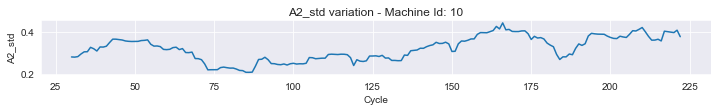

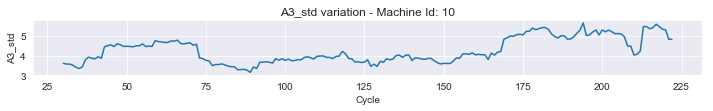

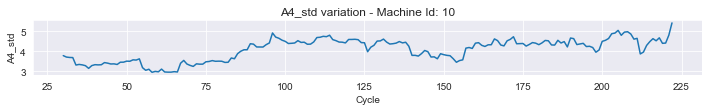

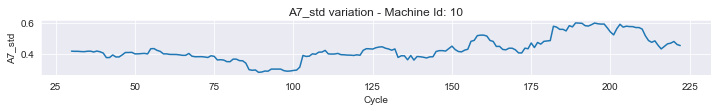

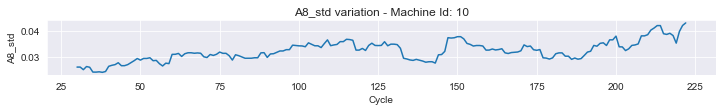

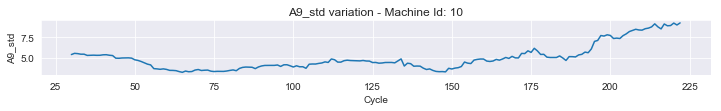

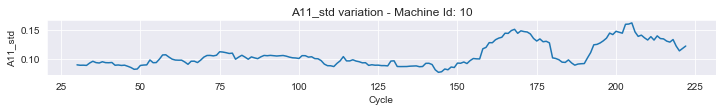

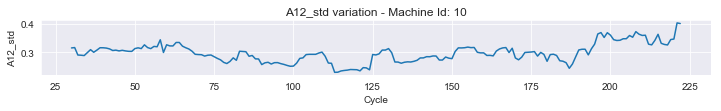

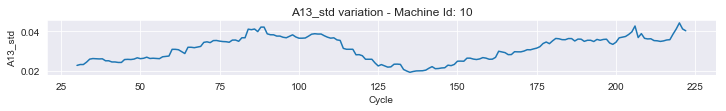

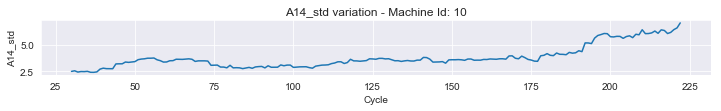

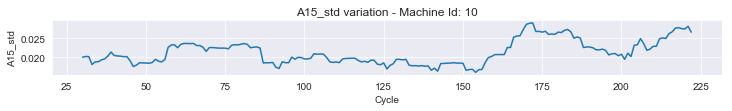

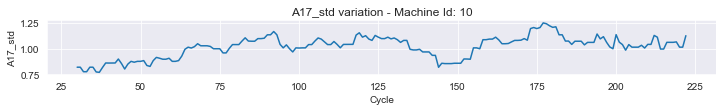

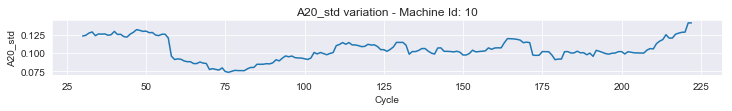

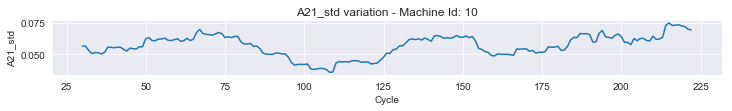

In [27]:
# We show an example graph of the rolling std of measurments for machine Id 10 during Training phase.

machine_id = 10
colum = [ c for c in feat_std.columns if c not in ['id','cycle'] ]
for i,col in enumerate(colum):
    plot_df = pd.DataFrame()
    temp = feat_std.loc[(feat_std["id"] == machine_id), ["cycle", col] ]
    plot_df = temp.set_index(temp.cycle).drop("cycle", axis=1)
    #print(plot_df.head())
    #print(plot_df.describe())

    plt.figure(figsize=(12, 1))
    plt.plot(plot_df[col])
    plt.title("{} variation - Machine Id: {}".format(col,machine_id) )
    plt.ylabel(col)

    plt.xlabel("Cycle")
    plt.show()

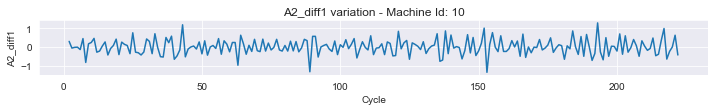

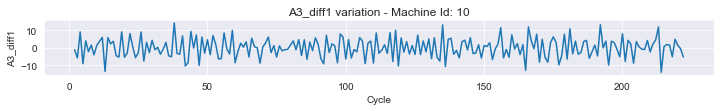

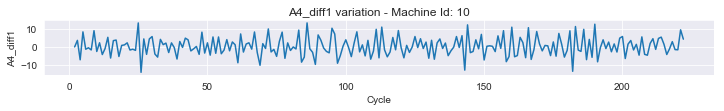

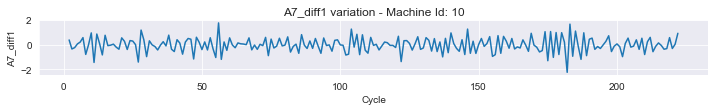

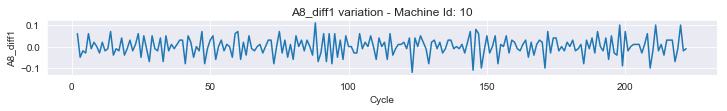

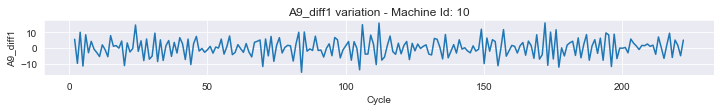

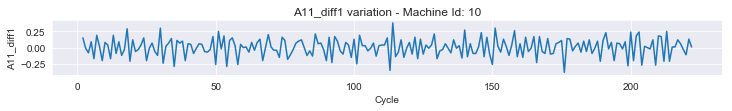

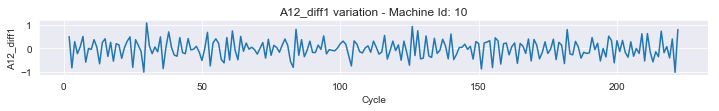

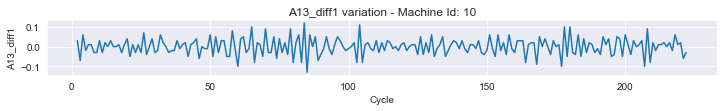

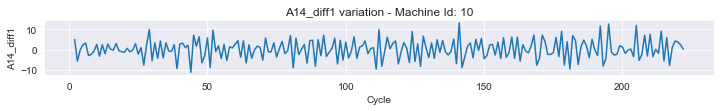

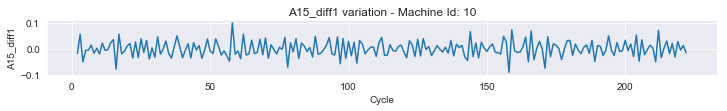

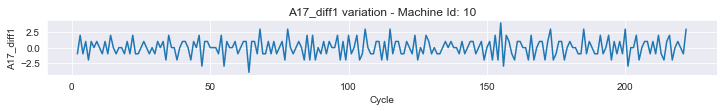

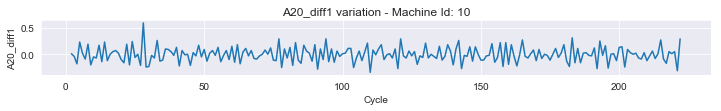

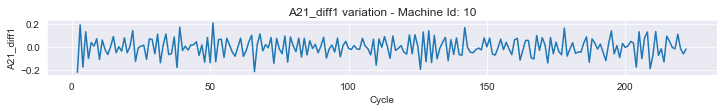

In [28]:
# We show an example graph of the differentiated measurments for machine Id 10 during Training phase.

machine_id = 10
colum = [ c for c in feat_diff.columns if c not in ['id','cycle'] ]
for i,col in enumerate(colum):
    plot_df = pd.DataFrame()
    temp = feat_diff.loc[(feat_diff["id"] == machine_id), ["cycle", col] ]
    plot_df = temp.set_index(temp.cycle).drop("cycle", axis=1)
    #print(plot_df.head())
    #print(plot_df.describe())

    plt.figure(figsize=(12, 1))
    plt.plot(plot_df[col])
    plt.title("{} variation - Machine Id: {}".format(col,machine_id) )
    plt.ylabel(col)

    plt.xlabel("Cycle")
    plt.show()

Let's merge new stationary features with our Training dataset.

In [29]:
feat_cols = ['id', 'cycle']
[feat_cols.append(a) for a in cols]
feat_cols

['id',
 'cycle',
 'control1',
 'control2',
 'A2',
 'A3',
 'A4',
 'A7',
 'A8',
 'A9',
 'A11',
 'A12',
 'A13',
 'A14',
 'A15',
 'A17',
 'A20',
 'A21']

In [30]:
dataset_train_statio = dataset_train[feat_cols].merge(feat_std,
                                            on=["id", "cycle"],
                                            how="left"
                                            ).fillna(0.0)

dataset_train_statio = dataset_train_statio.merge(feat_diff,
                                            on=["id", "cycle"],
                                            how="left"
                                            ).fillna(0.0)  #.drop(fields,axis=1)
dataset_train_statio.head()

,id,cycle,control1,control2,A2,A3,A4,A7,A8,A9,...,A8_diff1,A9_diff1,A11_diff1,A12_diff1,A13_diff1,A14_diff1,A15_diff1,A17_diff1,A20_diff1,A21_diff1
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.00,0.0000
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,...,-0.02,-2.12,0.02,0.62,0.05,-7.13,0.0123,0.0,-0.06,0.0046
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,...,0.04,8.87,-0.22,0.14,-0.04,1.74,-0.0140,-2.0,-0.05,-0.0794
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,...,0.03,-3.46,-0.14,0.44,0.05,0.60,-0.0496,2.0,-0.07,0.0297
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,...,-0.05,5.67,0.15,-0.67,-0.04,-0.03,0.0612,1.0,0.02,0.0305


In [31]:
dataset_train_statio.columns

Index(['id', 'cycle', 'control1', 'control2', 'A2', 'A3', 'A4', 'A7', 'A8',
       'A9', 'A11', 'A12', 'A13', 'A14', 'A15', 'A17', 'A20', 'A21', 'A2_std',
       'A3_std', 'A4_std', 'A7_std', 'A8_std', 'A9_std', 'A11_std', 'A12_std',
       'A13_std', 'A14_std', 'A15_std', 'A17_std', 'A20_std', 'A21_std',
       'A2_diff1', 'A3_diff1', 'A4_diff1', 'A7_diff1', 'A8_diff1', 'A9_diff1',
       'A11_diff1', 'A12_diff1', 'A13_diff1', 'A14_diff1', 'A15_diff1',
       'A17_diff1', 'A20_diff1', 'A21_diff1'],
      dtype='object')

## Loading Test Dataset

In [32]:
dataset_test=pd.read_csv('./data/PM_test.txt',sep=' ',header=None).drop([26,27],axis=1)
dataset_test.columns=col_names
#dataset_test.head()
print('Shape of Test dataset: ',dataset_test.shape)
dataset_test.head()

Shape of Test dataset:  (13096, 26)


,id,cycle,control1,control2,control3,A1,A2,A3,A4,A5,...,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [33]:
dataset_test.describe()

,id,cycle,control1,control2,control3,A1,A2,A3,A4,A5,...,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,13096.00,13096.000000,13096.000000,13096.000000,1.309600e+04,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,100.0,518.67,642.475088,1588.099204,1404.735362,1.462000e+01,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.0,0.00,0.400899,5.003274,6.688309,1.776425e-15,...,0.559627,0.056934,10.188605,0.029009,1.040874e-17,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,100.0,518.67,641.130000,1569.040000,1384.390000,1.462000e+01,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,100.0,518.67,642.197500,1584.600000,1399.950000,1.462000e+01,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,52.000000,69.000000,0.000000,0.000000,100.0,518.67,642.460000,1587.990000,1404.440000,1.462000e+01,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,100.0,518.67,642.740000,1591.362500,1409.050000,1.462000e+01,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,100.0,518.67,644.300000,1607.550000,1433.360000,1.462000e+01,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


In [34]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
id          13096 non-null int64
cycle       13096 non-null int64
control1    13096 non-null float64
control2    13096 non-null float64
control3    13096 non-null float64
A1          13096 non-null float64
A2          13096 non-null float64
A3          13096 non-null float64
A4          13096 non-null float64
A5          13096 non-null float64
A6          13096 non-null float64
A7          13096 non-null float64
A8          13096 non-null float64
A9          13096 non-null float64
A10         13096 non-null float64
A11         13096 non-null float64
A12         13096 non-null float64
A13         13096 non-null float64
A14         13096 non-null float64
A15         13096 non-null float64
A16         13096 non-null float64
A17         13096 non-null int64
A18         13096 non-null int64
A19         13096 non-null float64
A20         13096 non-null float64
A21         13096 non-nu

Any missing values?

In [35]:
for col in dataset_test.columns:
    nancnt = dataset_test[col].isnull().sum()
    print("%16s %s nan" % (col, str(nancnt)))

              id 0 nan
           cycle 0 nan
        control1 0 nan
        control2 0 nan
        control3 0 nan
              A1 0 nan
              A2 0 nan
              A3 0 nan
              A4 0 nan
              A5 0 nan
              A6 0 nan
              A7 0 nan
              A8 0 nan
              A9 0 nan
             A10 0 nan
             A11 0 nan
             A12 0 nan
             A13 0 nan
             A14 0 nan
             A15 0 nan
             A16 0 nan
             A17 0 nan
             A18 0 nan
             A19 0 nan
             A20 0 nan
             A21 0 nan


Let's do same features engineering as for Training dataset (stationarity).

In [36]:
# Select the set of variables from our previous correlation analysis 
feat_cols

['id',
 'cycle',
 'control1',
 'control2',
 'A2',
 'A3',
 'A4',
 'A7',
 'A8',
 'A9',
 'A11',
 'A12',
 'A13',
 'A14',
 'A15',
 'A17',
 'A20',
 'A21']

Let's transform non-stationary features through their 1st degree differential and rolling STD (volatility).

In [37]:

vol_period = 30  # STD rolling window size (cycles = days)
temp1 = []
temp2 = []
feat_std = []
feat_diff = []
fields = [c for c in cols if c not in ['control1', 'control2']]

# we pivot because we need the cycle and machine_id as an index for "differentiation" to work on non-stationary
# features.
# unstack: returns df to the original format
# we have 100 machines + 14 non-stationary features = 1400 columns
# unstack shows a dataseries on the columns as index and returns series (if there are several indexes,then they are rearranged).
# Each 'temp' dataframe has the values of the field that corresponds to it at that moment.

temp1 = [
    pd.pivot_table(
        dataset_test,
        index="cycle",
        columns="id",
        values=col).rolling(vol_period).std().unstack()
    for col in fields
]

temp2 = [
    pd.pivot_table(
        dataset_test,
        index="cycle",
        columns="id",
        values=col).diff().unstack()
    for col in fields
]

feat_std = pd.concat(temp1, axis=1) # We join the series
feat_std.columns = [col + "_std" for col in fields] # We assign columns' name.
feat_std.reset_index(inplace=True) # reset the index.
#feat_std.fillna(0, inplace=True)
feat_std = feat_std.loc[-feat_std["A2_std"].isnull()]

feat_diff = pd.concat(temp2, axis=1) # We join the series
feat_diff.columns = [col + "_diff1" for col in fields] # We assign columns' name.
feat_diff.reset_index(inplace=True) # reset the index.
#feat_diff.fillna(0, inplace=True)
feat_diff = feat_diff.loc[-feat_diff["A2_diff1"].isnull()]
feat_diff.head()

,id,cycle,A2_diff1,A3_diff1,A4_diff1,A7_diff1,A8_diff1,A9_diff1,A11_diff1,A12_diff1,A13_diff1,A14_diff1,A15_diff1,A17_diff1,A20_diff1,A21_diff1
1,1,2,-1.31,3.16,-2.79,0.95,-0.03,4.25,0.30,0.44,0.03,14.07,-0.0249,1.0,0.16,0.0181
2,1,3,0.75,-1.51,5.92,-0.74,0.04,2.54,0.00,-0.19,-0.03,-9.52,0.0638,0.0,0.06,0.0250
3,1,4,-0.02,-2.82,5.08,-0.04,-0.02,-11.67,-0.22,-0.59,0.02,2.80,-0.0524,-2.0,-0.08,-0.0429
4,1,5,0.07,3.07,-4.50,0.09,-0.02,-0.74,0.03,0.77,-0.02,-3.36,0.0114,-1.0,-0.01,0.0393
5,1,6,-0.40,-8.07,-6.79,0.06,-0.01,6.41,-0.05,-0.23,0.05,-2.08,0.0207,2.0,-0.08,-0.0663


In [38]:
dataset_test_statio = dataset_test[feat_cols].merge(feat_std,
                                            on=["id", "cycle"],
                                            how="left"
                                            ).fillna(0.0)
dataset_test_statio = dataset_test_statio.merge(feat_diff,
                                            on=["id", "cycle"],
                                            how="left"
                                            ).fillna(0.0)  #.drop(fields,axis=1)

dataset_test_statio.head()

,id,cycle,control1,control2,A2,A3,A4,A7,A8,A9,...,A8_diff1,A9_diff1,A11_diff1,A12_diff1,A13_diff1,A14_diff1,A15_diff1,A17_diff1,A20_diff1,A21_diff1
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.00,0.0000
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,...,-0.03,4.25,0.30,0.44,0.03,14.07,-0.0249,1.0,0.16,0.0181
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,...,0.04,2.54,0.00,-0.19,-0.03,-9.52,0.0638,0.0,0.06,0.0250
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,...,-0.02,-11.67,-0.22,-0.59,0.02,2.80,-0.0524,-2.0,-0.08,-0.0429
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,...,-0.02,-0.74,0.03,0.77,-0.02,-3.36,0.0114,-1.0,-0.01,0.0393


### Loadind Truth table

Truth table provides for each machine (id), the number of days (cycles) left before failure (more).

In [39]:
pm_truth=pd.read_csv('./data/PM_truth.txt',sep=' ',header=None).drop([1],axis=1)
pm_truth.columns=['more']
pm_truth['id']=pm_truth.index+1
pm_truth.head()

,more,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [40]:
pm_truth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
more    100 non-null int64
id      100 non-null int64
dtypes: int64(2)
memory usage: 1.6 KB


In [41]:
pm_truth.dtypes

more    int64
id      int64
dtype: object

Any missing value?

In [42]:
for col in pm_truth.columns:
    nancnt = pm_truth[col].isnull().sum()
    print("%16s %s nan" % (col, str(nancnt)))

            more 0 nan
              id 0 nan


### Update Test dataset 
Generate column 'max' for test data, which will relate to the max number of cycles recorded for each machine (last timestamp).

In [43]:
rul = pd.DataFrame(dataset_test_statio.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

,id,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [44]:
rul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
id     100 non-null int64
max    100 non-null int64
dtypes: int64(2)
memory usage: 1.6 KB


We define the variable 'RunToFailure (rtf)' as the timestamp corresponding to failure = max(cycle) as the last recorded timestamp + the number of left cycles (more) before failure. 

In [45]:
# run to failure
pm_truth['rtf']=pm_truth['more']+rul['max']
pm_truth.head()

,more,id,rtf
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


Let's do some cleaning to the Truth table and merge it back to Test dataset.

In [46]:
pm_truth_clean = pm_truth.drop('more', axis=1)
dataset_test_statio=dataset_test_statio.merge(pm_truth_clean,on=['id'],how='left').fillna(0.0)
dataset_test_statio.head()

,id,cycle,control1,control2,A2,A3,A4,A7,A8,A9,...,A9_diff1,A11_diff1,A12_diff1,A13_diff1,A14_diff1,A15_diff1,A17_diff1,A20_diff1,A21_diff1,rtf
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,...,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.00,0.0000,143
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,...,4.25,0.30,0.44,0.03,14.07,-0.0249,1.0,0.16,0.0181,143
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,...,2.54,0.00,-0.19,-0.03,-9.52,0.0638,0.0,0.06,0.0250,143
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,...,-11.67,-0.22,-0.59,0.02,2.80,-0.0524,-2.0,-0.08,-0.0429,143
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,...,-0.74,0.03,0.77,-0.02,-3.36,0.0114,-1.0,-0.01,0.0393,143


Let's calculate 'TimeToFailure (ttf)" variable as being equal RunToFailure (rtf) - actual timestamp (cycle) of the record for each machine.

In [47]:
dataset_test_statio['ttf']=dataset_test_statio['rtf'] - dataset_test_statio['cycle']
dataset_test_statio.drop('rtf', axis=1, inplace=True)
dataset_test_statio.head()

,id,cycle,control1,control2,A2,A3,A4,A7,A8,A9,...,A9_diff1,A11_diff1,A12_diff1,A13_diff1,A14_diff1,A15_diff1,A17_diff1,A20_diff1,A21_diff1,ttf
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,...,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.00,0.0000,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,...,4.25,0.30,0.44,0.03,14.07,-0.0249,1.0,0.16,0.0181,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,...,2.54,0.00,-0.19,-0.03,-9.52,0.0638,0.0,0.06,0.0250,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,...,-11.67,-0.22,-0.59,0.02,2.80,-0.0524,-2.0,-0.08,-0.0429,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,...,-0.74,0.03,0.77,-0.02,-3.36,0.0114,-1.0,-0.01,0.0393,138


And update our training dataset with 'TimeToFailure (ttf)' variable. We assume max value of timestamp (cycle) in the Training dataset, relates to failure time stamp ('more' = 0 and rtf= max_cycle ). Therefore ttf = rtf - cycle for our training records !

In [48]:
dataset_train_statio['ttf'] = dataset_train_statio.groupby(['id'])['cycle'].transform(max)-dataset_train_statio['cycle']
dataset_train_statio.head()

,id,cycle,control1,control2,A2,A3,A4,A7,A8,A9,...,A9_diff1,A11_diff1,A12_diff1,A13_diff1,A14_diff1,A15_diff1,A17_diff1,A20_diff1,A21_diff1,ttf
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,...,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.00,0.0000,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,...,-2.12,0.02,0.62,0.05,-7.13,0.0123,0.0,-0.06,0.0046,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,...,8.87,-0.22,0.14,-0.04,1.74,-0.0140,-2.0,-0.05,-0.0794,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,...,-3.46,-0.14,0.44,0.05,0.60,-0.0496,2.0,-0.07,0.0297,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,...,5.67,0.15,-0.67,-0.04,-0.03,0.0612,1.0,0.02,0.0305,187


## Construct Labels

We build a binary label related to our business problem which is to predict which machine will fail within next 30 days (cycles). 1 if machine_id will fail within next 30 cycles. O otherwise.

In [49]:
df_train=dataset_train_statio.copy()
df_test=dataset_test_statio.copy()

period=30

df_train['label'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
df_test['label'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)
df_train.head()

,id,cycle,control1,control2,A2,A3,A4,A7,A8,A9,...,A11_diff1,A12_diff1,A13_diff1,A14_diff1,A15_diff1,A17_diff1,A20_diff1,A21_diff1,ttf,label
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,...,0.00,0.00,0.00,0.00,0.0000,0.0,0.00,0.0000,191,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,...,0.02,0.62,0.05,-7.13,0.0123,0.0,-0.06,0.0046,190,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,...,-0.22,0.14,-0.04,1.74,-0.0140,-2.0,-0.05,-0.0794,189,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,...,-0.14,0.44,0.05,0.60,-0.0496,2.0,-0.07,0.0297,188,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,...,0.15,-0.67,-0.04,-0.03,0.0612,1.0,0.02,0.0305,187,0


### Features importance

In [50]:

features_col_name = [c for c in df_train.columns if c not in ['id', 'cycle', 'ttf', 'label']]
target_col_name='label'

Bear in minf that 'ttf' is used to elaborate our 'target' value !!

#### Method 1 (ensemble trees)

In [51]:
# Model training.
# model = GradientBoostingClassifier(random_state=42)
model = xgb()
model.fit(df_train[features_col_name] , df_train[target_col_name] );

Let's plot feautures importance derived from our boosted tree ensemble algorithm. 

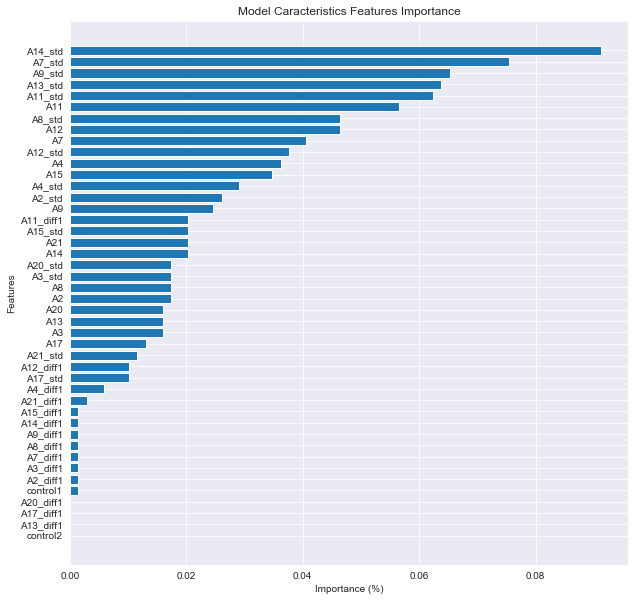

In [52]:
plt.figure(figsize=(10, 10))
labels, importances = zip(*sorted(zip(features_col_name, model.feature_importances_), reverse=False, key=lambda x: x[1]))
plt.yticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.barh(range(len(importances)), importances)
plt.ylabel("Features")
plt.xlabel("Importance (%)")
plt.title("Model Caracteristics Features Importance")
plt.show()

In [53]:
df_temp = pd.DataFrame(model.feature_importances_, columns = ["importance"], index = features_col_name)
df_temp.sort_values(by=["importance"], ascending=False, inplace = True)
df_temp

,importance
A14_std,0.091304
A7_std,0.075362
A9_std,0.065217
A13_std,0.063768
A11_std,0.062319
A11,0.056522
A12,0.046377
A8_std,0.046377
A7,0.040580
A12_std,0.037681


We notice that, on top of variables taken off from the correlation analysis, control2 and 1st degree differentials of A13, A17 and A20 bring no additional information !

In [54]:
select_feat_xgb = list(df_temp[df_temp["importance"] > 0.0 ].index)

select_feat_xgb

['A14_std',
 'A7_std',
 'A9_std',
 'A13_std',
 'A11_std',
 'A11',
 'A12',
 'A8_std',
 'A7',
 'A12_std',
 'A4',
 'A15',
 'A4_std',
 'A2_std',
 'A9',
 'A15_std',
 'A21',
 'A14',
 'A11_diff1',
 'A3_std',
 'A8',
 'A2',
 'A20_std',
 'A20',
 'A13',
 'A3',
 'A17',
 'A21_std',
 'A12_diff1',
 'A17_std',
 'A4_diff1',
 'A21_diff1',
 'A3_diff1',
 'A7_diff1',
 'A8_diff1',
 'A9_diff1',
 'A2_diff1',
 'A14_diff1',
 'A15_diff1',
 'control1']

#### Method 2 (PCA - dimension reduction / variance importance)

In [55]:
# Define variance importance threshold (in %)
threshold = 0.95

df_in = df_train[features_col_name].copy()
# pre-processing
scaler = StandardScaler()
df_features_center = scaler.fit_transform(df_in)
cols = df_in.columns
idx = df_in.index
    
# SVD method
eig_val, eig_vec = np.linalg.eig(np.cov(df_features_center.transpose()))
eig_index=np.argsort(eig_val)[::-1]  # extract eigenvalues indexes of decreasing higest variance directions
eigen_ratio = eig_val[eig_index]/np.sum(eig_val[eig_index])
    
# Projected features onto Eigen-vectors subspace
df_features_transf =(df_features_center).dot(eig_vec[:,eig_index]) / np.sqrt(eig_val[eig_index])
# transform it to a Pandas dataframe.
tmp_cols = cols[eig_index]
df_features_transf = pd.DataFrame(df_features_transf, columns = tmp_cols)
df_features_transf.index = idx

select_feat_svd = tmp_cols[0:np.argmin(np.cumsum(eigen_ratio) <= threshold)]
    
print("Top features selected = {}".format(len(select_feat_svd)))

# final DataFrame to be used
df_out = df_features_transf[select_feat_svd] 
for c in select_feat_svd:
    print(str(c))

Top features selected = 21
control1
control2
A2
A3
A7
A8
A9
A14
A20
A21
A2_std
A4_std
A3_std
A17
A15
A13
A12
A11
A4
A7_std
A11_std


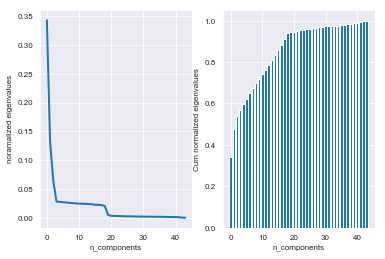

In [56]:
fig, ax = plt.subplots(1,2)
font = {'weight' : 'normal',
        'size'   : 8}
plt.rc('font', **font)
#plt.figure(figsize=(8, 5))

plt.subplot(1,2,1)
plt.plot(eigen_ratio, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('noramalized eigenvalues')
plt.grid(True)

plt.subplot(1,2,2)
plt.bar(x = range(0,len(eig_index)), height = np.cumsum(eigen_ratio[eig_index]))
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('Cum normalized eigenvalues')
plt.grid(True)

plt.show()

### Class imbalance check

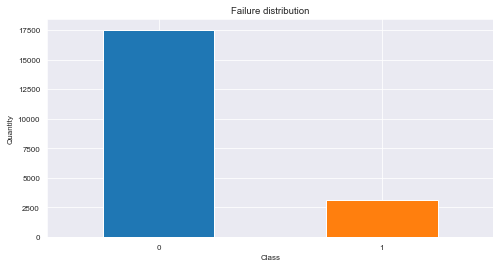

In [57]:
plt.figure(figsize=(8, 4))
df_train["label"].value_counts().plot(kind="bar", rot=0)
plt.title("Failure distribution")
plt.xlabel("Class")
plt.ylabel("Quantity")
plt.show()

#### Minority class oversampling

Must make sure we oversample only the training dataset !

In [58]:
from sklearn.utils import resample

# Separate input features and target
y = df_train["label"]
X = df_train.drop("label", axis=1)

# separate minority and majority classes
no_fail = df_train[df_train.label == 0]
fail    = df_train[df_train.label == 1]

In [59]:
fail.shape

(3100, 48)

In [60]:
# upsample minority
fail_upsampled = resample(fail,
                          replace=True, # sample with replacement
                          n_samples=no_fail.shape[0], # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
df_train_upsampled = pd.concat([no_fail, fail_upsampled])

# check new class counts
df_train_upsampled.label.value_counts()

1    17531
0    17531
Name: label, dtype: int64

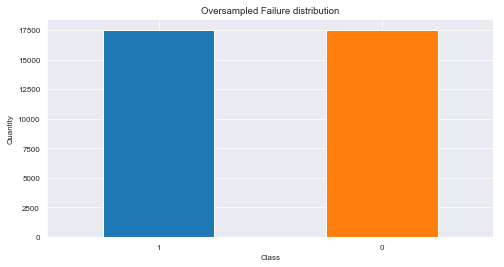

In [61]:
plt.figure(figsize=(8, 4))
df_train_upsampled["label"].value_counts().plot(kind="bar", rot=0)
plt.title("Oversampled Failure distribution")
plt.xlabel("Class")
plt.ylabel("Quantity")
plt.show()

## Features Scaling

In [62]:
# Features selection - Before Dimension reduction
features_col_name

['control1',
 'control2',
 'A2',
 'A3',
 'A4',
 'A7',
 'A8',
 'A9',
 'A11',
 'A12',
 'A13',
 'A14',
 'A15',
 'A17',
 'A20',
 'A21',
 'A2_std',
 'A3_std',
 'A4_std',
 'A7_std',
 'A8_std',
 'A9_std',
 'A11_std',
 'A12_std',
 'A13_std',
 'A14_std',
 'A15_std',
 'A17_std',
 'A20_std',
 'A21_std',
 'A2_diff1',
 'A3_diff1',
 'A4_diff1',
 'A7_diff1',
 'A8_diff1',
 'A9_diff1',
 'A11_diff1',
 'A12_diff1',
 'A13_diff1',
 'A14_diff1',
 'A15_diff1',
 'A17_diff1',
 'A20_diff1',
 'A21_diff1']

In [63]:
# Features selection - After Dimension reduction - XGboost method
select_feat_xgb

['A14_std',
 'A7_std',
 'A9_std',
 'A13_std',
 'A11_std',
 'A11',
 'A12',
 'A8_std',
 'A7',
 'A12_std',
 'A4',
 'A15',
 'A4_std',
 'A2_std',
 'A9',
 'A15_std',
 'A21',
 'A14',
 'A11_diff1',
 'A3_std',
 'A8',
 'A2',
 'A20_std',
 'A20',
 'A13',
 'A3',
 'A17',
 'A21_std',
 'A12_diff1',
 'A17_std',
 'A4_diff1',
 'A21_diff1',
 'A3_diff1',
 'A7_diff1',
 'A8_diff1',
 'A9_diff1',
 'A2_diff1',
 'A14_diff1',
 'A15_diff1',
 'control1']

In [64]:
# Features selection - After Dimension reduction - SVD method
list(select_feat_svd)

['control1',
 'control2',
 'A2',
 'A3',
 'A7',
 'A8',
 'A9',
 'A14',
 'A20',
 'A21',
 'A2_std',
 'A4_std',
 'A3_std',
 'A17',
 'A15',
 'A13',
 'A12',
 'A11',
 'A4',
 'A7_std',
 'A11_std']

Let's pick the selected features

In [65]:
# Features selection (post- importance or post- dimension reduction)
#select_cols=features_col_name  # full features
#select_cols=select_feat_svd    # dimension reduction
select_cols=select_feat_xgb    # Ensemble trees importance

In [66]:
#sc=MinMaxScaler()
sc=StandardScaler()
df_train[select_cols]=sc.fit_transform(df_train[select_cols])                       # no class balancing
#df_train_upsampled[select_cols]=sc.fit_transform(df_train_upsampled[select_cols])  # with class balancing
df_test[select_cols]=sc.transform(df_test[select_cols])

## Binary classification modeling (Logistic, RandomForest)

In [67]:
# Grid parameters for Logistic regression classifier
param_grid1 = [{
             'C'     : [0.1, 0.5, 1.0, 2.0, 10.0] ,
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }]

# Grid parameters for RandomForestClassifier classifier
param_grid2 = [{
             'n_estimators' : [2, 3, 5, 10, 20, 30, 50, 100], 
             'max_depth'    : [1, 2, 3, 5, 7, 10, 15]
             }]

param_grid = {'logit' : param_grid1,
              'RanForest': param_grid2
             }


In [68]:
param_grid['RanForest']

[{'n_estimators': [2, 3, 5, 10, 20, 30, 50, 100],
  'max_depth': [1, 2, 3, 5, 7, 10, 15]}]

In [73]:
models = {'clf1': LogisticRegression(penalty='l2', 
                                         C=1.0, 
                                         fit_intercept=True, 
                                         class_weight="balanced", # "balanced" or "None"
                                         random_state=None, 
                                         solver='liblinear', 
                                         max_iter=100, 
                                         verbose=0, 
                                         warm_start=False, 
                                         n_jobs=-1),
              
          'clf2': RandomForestClassifier(n_estimators='warn', 
                                             criterion='gini', 
                                             max_depth=None, 
                                             min_samples_split=2, 
                                             min_samples_leaf=1, 
                                             max_features='auto',  
                                             n_jobs=-1, 
                                             random_state=None, 
                                             verbose=0, 
                                             warm_start=False, 
                                             class_weight="balanced")  # "balanced" or "None"
             }

We choose 'f1' metric for imbalanced classes and 'accuracy' otherwise. 

In [74]:
%%time
search = []

for i, (clf,param) in enumerate(zip(models, param_grid)):
    print("Gridsearch step for classifier %d" % (i+1))
    
    clf_temp = GridSearchCV(models[clf], param_grid[param], iid=False, cv=5, scoring='f1')  #scoring='accuracy', roc_auc', 'f1'
    
    clf_temp.fit(df_train[select_cols], df_train['label'])                      # imbalanced classes
    #clf_temp.fit(df_train_upsampled[select_cols], df_train_upsampled['label'])  # balanced classes
    search.append(clf_temp)
    print("Best parameter for classifier {} (CV score={}):".format(clf,search[i].best_score_))
    print(search[i].best_params_)

    #clf.set_params(**search.best_params_)
    models[clf] = search[i].best_estimator_

    print()
    print(models[clf].get_params)
    print()
    


Gridsearch step for classifier 1
Best parameter for classifier clf1 (CV score=0.8942598940829782):
{'C': 1.0, 'solver': 'newton-cg'}

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)>

Gridsearch step for classifier 2
Best parameter for classifier clf2 (CV score=0.8939602451202979):
{'max_depth': 10, 'n_estimators': 100}

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
 

In [75]:
models

{'clf1': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
           solver='newton-cg', tol=0.0001, verbose=0, warm_start=False),
 'clf2': RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=10, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_jobs=-1, oob_score=False,
             random_state=None, verbose=0, warm_start=False)}

In [76]:
np.mean(search[0].cv_results_['mean_test_score'])

0.8922238169204607

In [77]:
np.mean(search[0].cv_results_['std_test_score'])

0.023517155905365135

#### Training metrics

Models trained on 'imbalanced' training dataset.

In [79]:
for i,clf in enumerate(models):
    res = models[clf].score(df_train[select_cols], df_train['label']) 
    #res = models[clf].score(df_train_upsampled[select_cols], df_train_upsampled['label'])# unbalanced classes
    error = np.mean(search[i].cv_results_['std_train_score'])
    print("Training score for classifier {}: {:0.4f} +/- {:0.6f}".format(clf,res, error)) # balanced classes

Training score for classifier clf1: 0.9682 +/- 0.005411
Training score for classifier clf2: 0.9896 +/- 0.007752


In [80]:
models['clf1'].classes_

array([0, 1], dtype=int64)

### Evaluation

#### Test metrics

In [81]:
# Test metrics
predict = {}
yhat = {}

for i,clf in enumerate(models):
    yhat['y_pred']       = models[clf].predict(df_test[select_cols])
    yhat['y_pred_proba'] = models[clf].predict_proba(df_test[select_cols])
    predict[clf] = yhat 
    error = np.mean(search[i].cv_results_['std_test_score'])
    print('Accuracy score of classifier {} on test data: {:0.4f} +/- {:0.6f}' \
                             .format(clf, 
                             accuracy_score(df_test['label'],yhat['y_pred']),
                             #f1_score(df_test['label'],yhat['y_pred']),
                             error) )

Accuracy score of classifier clf1 on test data: 0.9897 +/- 0.023517
Accuracy score of classifier clf2 on test data: 0.9895 +/- 0.027236


In [83]:
# Test metrics

target_names = ['No-fail', 'Fail']

for i,clf in enumerate(models):
    print('Accuracy score of classifier {} on test data'.format(clf))
    print(classification_report(df_test['label'],yhat['y_pred'], target_names=target_names))
    print()

Accuracy score of classifier clf1 on test data
              precision    recall  f1-score   support

     No-fail       1.00      0.99      0.99     12764
        Fail       0.78      0.81      0.80       332

   micro avg       0.99      0.99      0.99     13096
   macro avg       0.89      0.90      0.90     13096
weighted avg       0.99      0.99      0.99     13096


Accuracy score of classifier clf2 on test data
              precision    recall  f1-score   support

     No-fail       1.00      0.99      0.99     12764
        Fail       0.78      0.81      0.80       332

   micro avg       0.99      0.99      0.99     13096
   macro avg       0.89      0.90      0.90     13096
weighted avg       0.99      0.99      0.99     13096




In [84]:
predict['clf2']['y_pred'][:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [85]:
df_test['label'].sum(), np.sum(predict['clf1']['y_pred']), np.sum(predict['clf2']['y_pred'])

(332, 346, 346)

In [86]:
predict['clf2']['y_pred_proba'][:5]

array([[9.99450388e-01, 5.49612440e-04],
       [9.99679000e-01, 3.21000428e-04],
       [9.99499678e-01, 5.00322037e-04],
       [9.99690384e-01, 3.09616463e-04],
       [9.99679000e-01, 3.21000428e-04]])

#### Confusion Matrix

CONFUSIN MATRIX FOR CLASSIFIER clf1


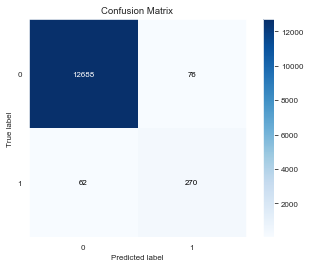

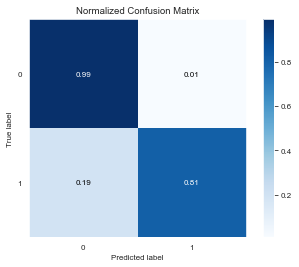

                                           0         1
accuracy                            0.989462  0.989462
precision                           0.995137  0.780347
recall                              0.994046  0.813253
F1                                  0.994591  0.796460
macro precision                     0.887742  0.887742
macro recall                        0.903649  0.903649
macro F1                            0.895526  0.895526
average accuracy                    0.989462  0.989462
micro-averaged precision/recall/F1  0.989462  0.989462
majority class accuracy             0.974649  0.000000
majority class recall               1.000000  0.000000
majority class precision            0.974649  0.000000
majority class F1                   0.987162  0.000000
expected accuracy                   0.949568  0.949568
kappa                               0.791054  0.791054
random guess accuracy               0.500000  0.500000
random guess precision              0.974649  0.025351
random gue

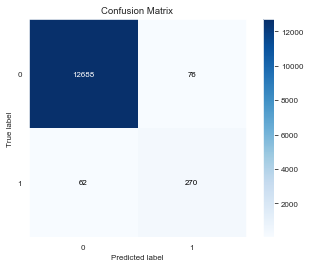

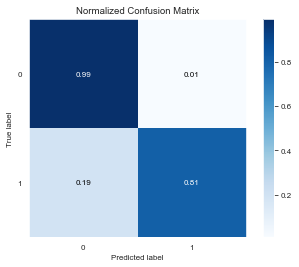

                                           0         1
accuracy                            0.989462  0.989462
precision                           0.995137  0.780347
recall                              0.994046  0.813253
F1                                  0.994591  0.796460
macro precision                     0.887742  0.887742
macro recall                        0.903649  0.903649
macro F1                            0.895526  0.895526
average accuracy                    0.989462  0.989462
micro-averaged precision/recall/F1  0.989462  0.989462
majority class accuracy             0.974649  0.000000
majority class recall               1.000000  0.000000
majority class precision            0.974649  0.000000
majority class F1                   0.987162  0.000000
expected accuracy                   0.949568  0.949568
kappa                               0.791054  0.791054
random guess accuracy               0.500000  0.500000
random guess precision              0.974649  0.025351
random gue

In [87]:
# Transform target and prediction into dataframes
truth = pd.DataFrame(data = df_test['label'].values, columns=["Fail"], dtype="int16")
for clf in models:
    pred  = pd.DataFrame(data = predict[clf]['y_pred'], columns=["Fail"], dtype="int16")

    evaluation_result = Evaluate(actual = truth,
                                 predicted = pred,
                                 labels = [0,1])
    # Plot confusion matrix
    #fig, ax = plt.subplots(1,2)
    #font = {'weight' : 'normal',
    #        'size'   : 8}
    #plt.rc('font', **font)
    #plt.figure(figsize=(8, 5))

    #plt.subplot(1,2,1)
    print("CONFUSIN MATRIX FOR CLASSIFIER {}".format(clf))
    skplt.metrics.plot_confusion_matrix(truth, pred, normalize=False, title="Confusion Matrix")
    #plt.subplot(1,2,2)
    skplt.metrics.plot_confusion_matrix(truth, pred, normalize=True, title="Normalized Confusion Matrix")
    plt.show()

    print(evaluation_result)  # show full results for first split only
    print("\n\n")

In [88]:
df_test['label'].shape, predict['clf1']['y_pred_proba'].shape

((13096,), (13096, 2))

In [89]:
predict['clf1']['y_pred_proba'][:10,1].shape

(10,)

#### ROC Curves

ROC CURVE FOR CLASSIFIER clf1


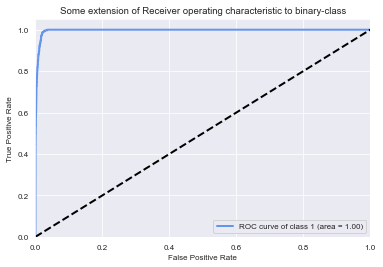




ROC CURVE FOR CLASSIFIER clf2


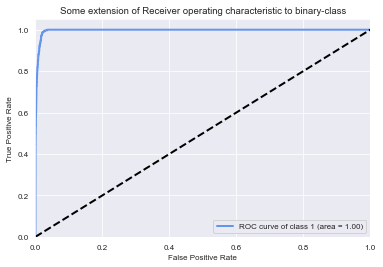

In [90]:
for clf in models:
    print("ROC CURVE FOR CLASSIFIER {}".format(clf))
    plot_binary_roc_curve(df_test['label'].values, predict[clf]['y_pred_proba'][:,1] )
    print("\n\n")

In [91]:
def clf_prob_failure(machine_id, clf):
    machine_test = df_test.loc[df_test.id==machine_id, select_cols]
    m_pred = clf.predict_proba(machine_test)[:,1]
    failure_prob = m_pred[-1]*100
    return failure_prob

In [92]:
idmax = df_test.id.max() 
for clf in models:
    count = 0
    print("PREDICTING FAILING MACHINES WITH CLASSIFIER {}".format(clf))
    for k in range(idmax):
        machine_id= k+1
        if clf_prob_failure(machine_id, models[clf]) > 85.0:
            count += 1
            print('Probability that machine Id_{} will fail within 30 days = {} %'\
                  .format(machine_id, np.round(clf_prob_failure(machine_id, models[clf]),decimals=2)))

    print("\n{} machines over {} will fail within 30 days = {} % ".format(count, idmax, np.round(count/idmax *100, decimals=2)))
    print("\n\n")

PREDICTING FAILING MACHINES WITH CLASSIFIER clf1
Probability that machine Id_18 will fail within 30 days = 91.4 %
Probability that machine Id_20 will fail within 30 days = 99.99 %
Probability that machine Id_24 will fail within 30 days = 99.92 %
Probability that machine Id_31 will fail within 30 days = 100.0 %
Probability that machine Id_34 will fail within 30 days = 100.0 %
Probability that machine Id_35 will fail within 30 days = 99.94 %
Probability that machine Id_36 will fail within 30 days = 99.08 %
Probability that machine Id_37 will fail within 30 days = 99.49 %
Probability that machine Id_40 will fail within 30 days = 87.04 %
Probability that machine Id_41 will fail within 30 days = 99.77 %
Probability that machine Id_42 will fail within 30 days = 100.0 %
Probability that machine Id_49 will fail within 30 days = 99.96 %
Probability that machine Id_52 will fail within 30 days = 87.22 %
Probability that machine Id_53 will fail within 30 days = 93.7 %
Probability that machine Id_5

RandomForest classifier model shows almost similar scores (slightly better) than Baseline Logistic regression classifier, with a recall of 81% / precision of 78% for class 1 ('Fail'). Therefore, these 2 classifiers do predict 14 to 26 machines that will 'fail' within the next 30 cycles ! 

## NeuralNet Modeling (LSTM)

Let's try to improve the recall score for our predictions by selecting a new family of models. For the sake of this analysis, we decided to develop a LSTM neuralNet. The underlying purpose of such a choice, si to take into consideration past correlations and time memory effect within our features time-series.   

#### Reshape our datasets for NNets models

In [93]:
# function to generate time-lagged dataset
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [94]:
# NeuralNets fitting history storage dataframe
def nn_perf(hist, verbose = True):

    frame = pd.DataFrame(np.zeros((len(hist.history['loss']),5)), columns = ['iter', 'loss','acc', 'val_loss','val_acc'] )

    for i in range(len(hist.history['loss'])):
        frame.iter.iloc[i] = i
        frame.loss.iloc[i] = hist.history['loss'][i]
        frame.acc.iloc[i] = hist.history['acc'][i]
        frame.val_loss.iloc[i] = hist.history['val_loss'][i]
        frame.val_acc.iloc[i] = hist.history['val_acc'][i]

    if verbose == True:
        print(frame)

    return(frame)

# NeuralNets plotting history performance values (accurary, loss)
def plot_nn_perf_fromframe(frame, fig = 1, verbose = True):

    if verbose == True:
        print(frame)
    # summarize history for accuracy
    plt.figure(fig)
    plt.plot(frame['acc'])
    plt.plot(frame['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()
    
    # summarize history for loss
    plt.figure(fig+1)
    plt.plot(frame['loss'])
    plt.plot(frame['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()

    return()

#### Generate Training datasets with time lags

In [95]:
# time steps or window size
seq_length=50  # cycles

# Features selection (post- importance or post- dimension reduction)
seq_cols=select_cols 

print("Number of selected features = {}".format(len(seq_cols)))
print("Time steps for each feature = {}".format(seq_length))

Number of selected features = 40
Time steps for each feature = 50


In [108]:
# generate X_train
# Without class balancing
X_train=np.concatenate(list(list(gen_sequence(df_train[df_train['id']==id], 
                                              seq_length, seq_cols)) for id in df_train['id'].unique()))

# With class balancing
#X_train=np.concatenate(list(list(gen_sequence(df_train_upsampled[df_train_upsampled['id']==id], 
#                                              seq_length, seq_cols)) for id in df_train_upsampled['id'].unique()))
print("New size of the Training dataset {}".format(X_train.shape))

# generate y_train
# Without class balancing
y_train=np.concatenate(list(list(gen_label(df_train[df_train['id']==id], 
                                           seq_length, seq_cols,'label')) for id in df_train['id'].unique()))

# With class balancing
#y_train=np.concatenate(list(list(gen_label(df_train_upsampled[df_train_upsampled['id']==id], 
#                                           seq_length, seq_cols,'label')) for id in df_train_upsampled['id'].unique()))
print("New size of the Training target {}".format(y_train.shape))

New size of the Training dataset (20531, 50, 40)
New size of the Training target (20531,)


#### Generate Test datasets with time lags

In [109]:
# generate X_test
X_test=np.concatenate(list(list(gen_sequence(df_test[df_test['id']==id], seq_length, seq_cols)) for id in df_test['id'].unique()))
print(X_test.shape)
# generate y_test
y_test=np.concatenate(list(list(gen_label(df_test[df_test['id']==id], 50, seq_cols,'label')) for id in df_test['id'].unique()))
print(y_test.shape)

(12996, 50, 40)
(12996,)


## LSTM Network

Let's build the neuralNet model.

In [131]:
nb_features =X_train.shape[2]
timestamp=seq_length

learning_adam = 0.0010 #0.0010
opt_adam = optimizers.Adam(lr=learning_adam, epsilon=1e-08, decay=8e-9)

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.45)) #0.3

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.45))  #0.3

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 50, 100)           56400     
_________________________________________________________________
dropout_17 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 86,651
Trainable params: 86,651
Non-trainable params: 0
_________________________________________________________________


In [132]:
%%time

epochs = 20      #10
batch_size = 300  #200 

# fit the network
hist = model.fit(X_train, y_train, 
                 epochs = epochs, 
                 batch_size = batch_size, 
                 validation_split=0.05,
                 shuffle = False,  # time-series records not iid !
                 class_weight = "balanced",  # to deal with imbalanced classes
                 callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto')],
                 verbose=1)

Train on 19504 samples, validate on 1027 samples
Epoch 1/20
19504/19504 [==============================] - 34s 2ms/step - loss: 0.2517 - acc: 0.8807 - val_loss: 0.1115 - val_acc: 0.9562
Epoch 2/20
19504/19504 [==============================] - 30s 2ms/step - loss: 0.1030 - acc: 0.9576 - val_loss: 0.0726 - val_acc: 0.9659
Epoch 3/20
19504/19504 [==============================] - 30s 2ms/step - loss: 0.0710 - acc: 0.9717 - val_loss: 0.0676 - val_acc: 0.9708
Epoch 4/20
19504/19504 [==============================] - 30s 2ms/step - loss: 0.0666 - acc: 0.9728 - val_loss: 0.0843 - val_acc: 0.9669
Epoch 5/20
19504/19504 [==============================] - 30s 2ms/step - loss: 0.0605 - acc: 0.9766 - val_loss: 0.0667 - val_acc: 0.9708
Epoch 6/20
19504/19504 [==============================] - 30s 2ms/step - loss: 0.0522 - acc: 0.9800 - val_loss: 0.0765 - val_acc: 0.9757
Epoch 7/20
19504/19504 [==============================] - 30s 2ms/step - loss: 0.0474 - acc: 0.9817 - val_loss: 0.0522 - val_acc:

Let's plot NNet model performance curves.

    iter      loss       acc  val_loss   val_acc
0    0.0  0.251700  0.880691  0.111472  0.956183
1    1.0  0.102961  0.957650  0.072573  0.965920
2    2.0  0.071007  0.971698  0.067602  0.970789
3    3.0  0.066619  0.972826  0.084273  0.966894
4    4.0  0.060511  0.976620  0.066674  0.970789
5    5.0  0.052181  0.980004  0.076527  0.975657
6    6.0  0.047397  0.981696  0.052246  0.978578
7    7.0  0.042066  0.984670  0.062003  0.978578
8    8.0  0.038986  0.984106  0.077813  0.974684
9    9.0  0.030752  0.988105  0.091233  0.971762
10  10.0  0.035212  0.985593  0.103265  0.963973
11  11.0  0.037215  0.984824  0.082876  0.972736


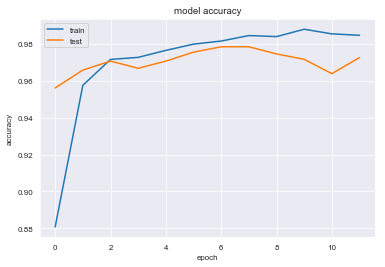

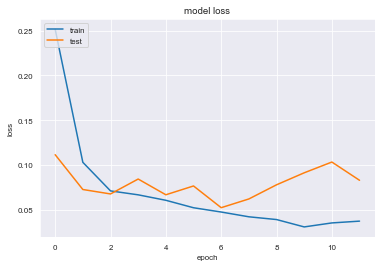

()

In [133]:
perf_nn = nn_perf(hist, verbose = True)
plot_nn_perf_fromframe(perf_nn, fig = 1, verbose = False)

### Evaluation

#### Training metrics

In [135]:
# training metrics
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=batch_size)
print('Accurracy: {:0.4f}'.format(scores[1]))

20531/20531 [==============================] - 14s 675us/step
Accurracy: 0.9849


#### Test metrics

In [136]:
%%time

# Test metrics
y_pred = model.predict_classes(X_test)
y_pred_proba = model.predict_proba(X_test)

print('Accuracy of model on test data: {:0.4f}'.format(accuracy_score(y_test,y_pred)))
#print('Confusion Matrix: \n',confusion_matrix(y_test,y_pred))

Accuracy of model on test data: 0.9931


In [115]:
y_pred.shape, y_pred_proba.shape

((12996, 1), (12996, 1))

In [137]:
y_pred_proba[:10]

array([[5.07104077e-05],
       [3.23579991e-05],
       [2.95216860e-05],
       [2.54952099e-05],
       [2.47025813e-05],
       [2.39943341e-05],
       [2.40631979e-05],
       [2.39100742e-05],
       [2.47989191e-05],
       [2.38330971e-05]])

#### Confusion Matrix

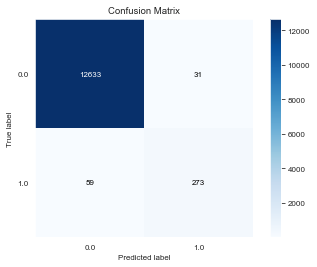

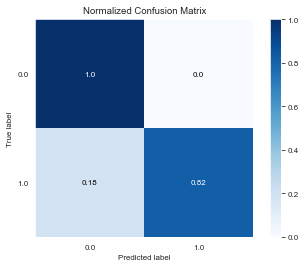

,0,1
accuracy,0.993075,0.993075
precision,0.995351,0.898026
recall,0.997552,0.822289
F1,0.996451,0.858491
macro precision,0.946689,0.946689
macro recall,0.909921,0.909921
macro F1,0.927471,0.927471
average accuracy,0.993075,0.993075
micro-averaged precision/recall/F1,0.993075,0.993075
majority class accuracy,0.974454,0.000000


In [138]:
# Transform target and prediction into dataframes
truth = pd.DataFrame(data = y_test, columns=["Fail"], dtype="int16")
pred  = pd.DataFrame(data = y_pred, columns=["Fail"], dtype="int16")

evaluation_result = Evaluate(actual = truth,
                             predicted = pred,
                             labels = [0,1])
# Plot confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, title="Confusion Matrix")

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, title="Normalized Confusion Matrix")
plt.show()

evaluation_result  # show full results for first split only

#### ROC Curve

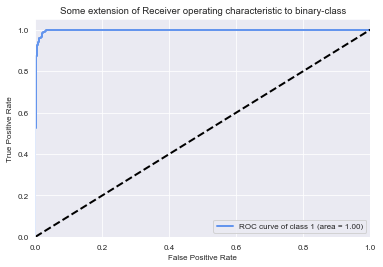

In [139]:
plot_binary_roc_curve(y_test, y_pred_proba)

The neuralNet classifier brings a small recall/f1 improvement for the imbalanced class 1 ('Fail') vs. LogReg and RandomForest classifiers, from 0.75 up to 0.78 (recall) and from 0.80 up to 0.82 (f1). 

We could eventually improve performance by either improving our features engineering task while adding knwoledge-based information of the underlying degradation physical phenomenon on the assets, or by adding additional complexity to the modeling task of our workflow. 

### Probability of Machine failure

In [119]:
def nnet_prob_failure(machine_id):
    machine_df=df_test[df_test.id==machine_id]
    machine_test=gen_sequence(machine_df,seq_length,seq_cols)
    m_pred=model.predict(machine_test)
    failure_prob=list(m_pred[-1]*100)[0]
    return failure_prob

In [140]:
idmax = df_test.id.max() 
count = 0
for k in range(idmax):
    machine_id= k+1
    if nnet_prob_failure(machine_id) > 85.0:
        count += 1
        print('Probability that machine Id_{} will fail within 30 days = {} %'\
              .format(machine_id, np.round(nnet_prob_failure(machine_id),decimals=2)))

print("\n{} machines over {} will fail within 30 days = {} % ".format(count, idmax, np.round(count/idmax *100, decimals=2)))

Probability that machine Id_20 will fail within 30 days = 99.71 %
Probability that machine Id_24 will fail within 30 days = 99.34 %
Probability that machine Id_31 will fail within 30 days = 99.85 %
Probability that machine Id_34 will fail within 30 days = 99.86 %
Probability that machine Id_35 will fail within 30 days = 99.87 %
Probability that machine Id_36 will fail within 30 days = 99.48 %
Probability that machine Id_37 will fail within 30 days = 98.12 %
Probability that machine Id_41 will fail within 30 days = 97.77 %
Probability that machine Id_42 will fail within 30 days = 99.79 %
Probability that machine Id_49 will fail within 30 days = 99.69 %
Probability that machine Id_56 will fail within 30 days = 99.81 %
Probability that machine Id_61 will fail within 30 days = 90.58 %
Probability that machine Id_64 will fail within 30 days = 99.18 %
Probability that machine Id_66 will fail within 30 days = 99.71 %
Probability that machine Id_68 will fail within 30 days = 99.83 %
Probabilit

NeuralNet classifier predicts 21 machines that will fail within the next 30 cycles with a probability higher than 85% (precision = 89.8% / recall = 82.2%).

RandomForest classifier predicts 14 machines that will fail within the next 30 cycles with a probability higher than 85% (precision = 78% / recall = 81%).

LogisticRegression classifier predicts 26 machines that will fail within the next 30 cycles with a probability higher than 85% (precision = 78% / recall = 81%).


